In [276]:
import pandas as pd
import numpy as np
import statistics
import random
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
import joblib
import plotly.graph_objs as pgo
import glob
import statsmodels
import statsmodels.api as sm


from sklearn.utils import shuffle
from math import*
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pylab as pl

from statsmodels.discrete.discrete_model import Probit


from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


plt.rc("font", size=14)

from sklearn.model_selection import train_test_split


In [274]:
###########################################################################
#                        TRAIN AND EVALUATE                             ###
###########################################################################
   
def train_and_evaluate(X_train, Y_train, X_test, Y_test, modelo):
    length_G1=0
    length_G2=0
    prevalence_G1=0
    prevalence_G2=0
    sensitivity=0
    specificity=0
    # Creating and training a model
    
    #                        CLASSIFIER GENERATION                          ###
    
    # LOGISTIC REGRESSION CLASSIFIER 
    if modelo=='Logistic':
        model = LogisticRegression(solver='liblinear',penalty="l1", class_weight="balanced",  random_state=None)

    #  MLP - NEURAL NETWORKS
    if modelo=='RN':
        model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='tanh', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.0005, power_t=0.5, 
                                                 max_iter=2000, shuffle=True, random_state=1, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=20)
    # LRANDOM FOREST
    if modelo=='RF':
        model = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=None, max_features="sqrt", n_jobs=25, bootstrap=True, warm_start=False)
        
    model.fit(X_train, Y_train)    
 


    # Save the model (Make sure that the folder exists)
    joblib.dump(model, 'models\\mlp_classifier.jbl')
    
    #                        CLASSIFIER EVALUATION                          ###
 
    # Evaluating on training data
    print('\n-- Training data --')
    predictions = model.predict(X_train)
    accuracy = sklearn.metrics.accuracy_score(Y_train, predictions)
    print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
    print('Classification Report:')
    print(sklearn.metrics.classification_report(Y_train, predictions))
    print('Confusion Matrix:')
    print(sklearn.metrics.confusion_matrix(Y_train, predictions))
    print('')
    
    
    # Evaluating on testing data
    print('\n---- Test data ----')
    # Testando com todo conjunto treino + teste
    #predictions = model.predict(np.concatenate((X_test,X_train), axis=0))
    #accuracy = sklearn.metrics.accuracy_score(np.concatenate((Y_test,Y_train), axis=0), predictions)
    
    predictions = model.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(Y_test, predictions)
 

    print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
    print('Classification Report:')
    print(sklearn.metrics.classification_report(Y_test, predictions))
    print('Confusion Matrix:')
    print('***********')
    matrix_confusao = sklearn.metrics.confusion_matrix(Y_test, predictions)

   #  calculating the prevalence in each group
    prevalence_inicial= (matrix_confusao[1,1] + matrix_confusao[1,0]) / (matrix_confusao[0,0] + matrix_confusao[0,1] + matrix_confusao[1,0] + matrix_confusao[1,1]) 
    prevalence_G1=matrix_confusao[1,0] / (matrix_confusao[1,0]+matrix_confusao[0,0])
    prevalence_G2=matrix_confusao[1,1] / ( matrix_confusao[0,1] + matrix_confusao[1,1])
    
    #  calculating the number of individuals in each group
    length_G1=matrix_confusao[0,0]+matrix_confusao[1,0]
    length_G2=matrix_confusao[0,1] + matrix_confusao[1,1]
    print("====================Prevalence original group = ", prevalence_inicial)
    print('Number of individuals in the original population ===>', (matrix_confusao[0,0] + matrix_confusao[0,1] + matrix_confusao[1,0] + matrix_confusao[1,1]))
    print('2 Groups: Prevalence in Group 1= ', prevalence_G1, 'Prevalence in Group 2= ', prevalence_G2)
    print('Number of individuals in Group 1:  ',length_G1, 'Number of individuals in Group 2: ',length_G2)
    
        
    sensitividade= matrix_confusao[1,1] / (matrix_confusao[1,1]+matrix_confusao[0,1])
    especificidade= matrix_confusao[0,0] / (matrix_confusao[0,0]+matrix_confusao[0,1])
    
    
    precision_1 = matrix_confusao[1,1] / (matrix_confusao[0,1]+matrix_confusao[1,1])
    recall_1= matrix_confusao[1,1] / (matrix_confusao[1,1]+matrix_confusao[1,0])
    F_measure_1= 2*(precision_1*recall_1)/(precision_1+recall_1)

    
    precision_0 = matrix_confusao[0,0] / (matrix_confusao[0,0]+matrix_confusao[1,0])
    recall_0= matrix_confusao[0,0] / (matrix_confusao[0,0]+matrix_confusao[0,1])
    F_measure_0= 2*(precision_0*recall_0)/(precision_0+recall_0)
    

   # auc com todos treino+teste
    auc = roc_auc_score(Y_test, predictions)
   
    print('AUC: %.2f' % auc)
    fpr, tpr, thresholds = roc_curve(Y_test, predictions)

    plot_roc_curve(fpr, tpr)
    
    return [accuracy, length_G1, length_G2, prevalence_G1, prevalence_G2, sensitividade, especificidade,auc, precision_1, recall_1, F_measure_1, precision_0, recall_0, F_measure_0]

###########################################################################
#                        PLOT_CLASSIFIER                                ###
###########################################################################
# Plot the classifier
def plot_classifier(X, Y):
    modelo='classificador'
    # Load the model
    model = joblib.load('models\\mlp_classifier.jbl')

    # Calculate
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Make predictions
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot diagram
    fig = plt.figure(figsize = (12, 8))
    plt.contourf(xx, yy, Z, cmap='ocean', alpha=0.25)
    plt.contour(xx, yy, Z, colors='w', linewidths=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap='Spectral')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    local='plots\\'+ modelo + '.png'
    #plt.savefig('plots\\mlp_classifier.png')
    plt.savefig(local)

###########################################################################
#                        PLOT_ROC_CURVE                                 ###
###########################################################################
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
###########################################################################
#                        SCALECOLUMNS                                   ###
###########################################################################
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(new_dados_Einstein[col])),columns=[col])
    return df



In [277]:
###############################################################
#
# PRE-PROCESSING: LOADING AND CLEANING THE DATASET
#
###############################################################
dados_Einstein = pd.read_csv('<dataset address>')

# Data must be cleaned for Nan
# Eliminate rows with morevthan 50% of empty values
# fill the blanks with averaging
# Do feature selection= do sensibility studies and marginal probabilities calculation for each attribute

X_linha2=dados_Einstein[[ '<set of attributes-independent variables>]]

Y_linha2 = new_dados_Einstein["<target attribute or class>"]



Pre-processing: Length of original dataset 5644 length of cleaned dataset:  603
List of Attributes:
['Patient ID' 'Patient age quantile' 'SARS-Cov-2 exam result'
 'Patient addmited to regular ward (1=yes, 0=no)'
 'Patient addmited to semi-intensive unit (1=yes, 0=no)'
 'Patient addmited to intensive care unit (1=yes, 0=no)' 'Hematocrit'
 'Hemoglobin' 'Platelets' 'Mean platelet volume ' 'Red blood Cells'
 'Lymphocytes' 'Mean corpuscular hemoglobin concentration\xa0(MCHC)'
 'Leukocytes' 'Basophils' 'Mean corpuscular hemoglobin (MCH)'
 'Eosinophils' 'Mean corpuscular volume (MCV)' 'Monocytes'
 'Red blood cell distribution width (RDW)' 'Serum Glucose'
 'Respiratory Syncytial Virus' 'Influenza A' 'Influenza B'
 'Parainfluenza 1' 'CoronavirusNL63' 'Rhinovirus/Enterovirus'
 'Coronavirus HKU1' 'Parainfluenza 3' 'Chlamydophila pneumoniae'
 'Adenovirus' 'Parainfluenza 4' 'Coronavirus229E' 'CoronavirusOC43'
 'Inf A H1N1 2009' 'Bordetella pertussis' 'Metapneumovirus' 'Neutrophils'
 'Urea' 'Protein

In [278]:
###############################################################
#
# DIVIDING THE DATASET BETWEEN TRAINING AND TESTING  - K_FOLDING
#
###############################################################
    
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_linha, Y_linha, test_size=0.3, random_state=5, stratify=Y_linha)



===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

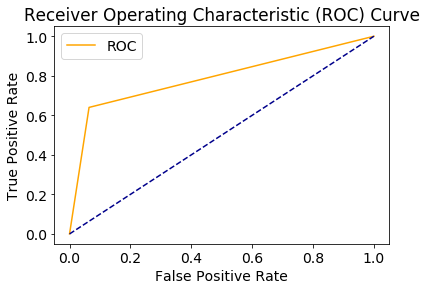

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

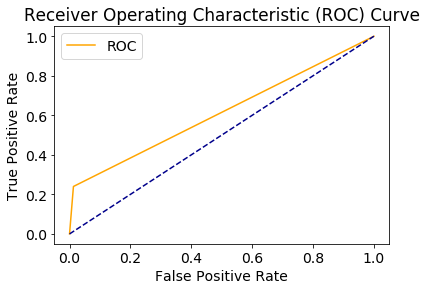

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

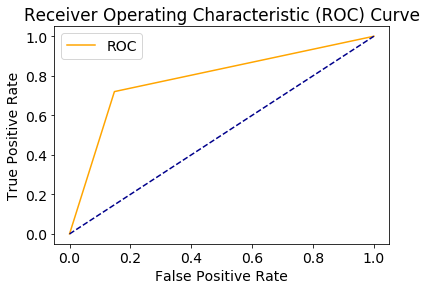

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

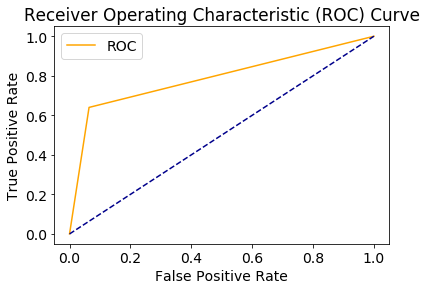

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       156
           1       0.67      0.32      0.43        25

    accuracy                           0.88       181
   macro avg       0.78      0.65      0.68       181
weighted avg       0.87      0.88      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

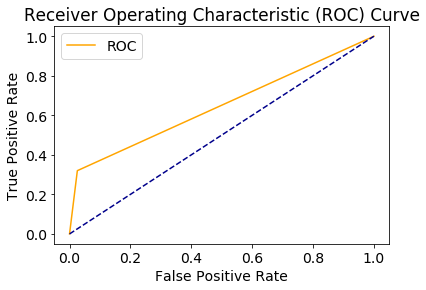

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

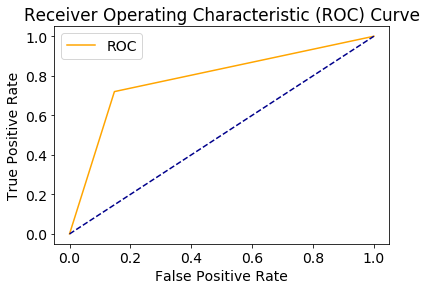

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

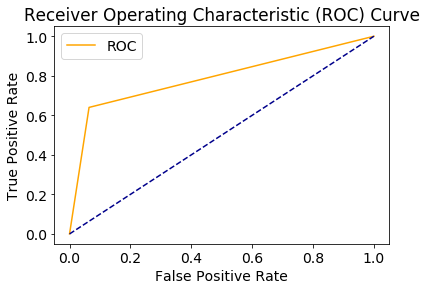

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       156
           1       0.67      0.24      0.35        25

    accuracy                           0.88       181
   macro avg       0.78      0.61      0.64       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

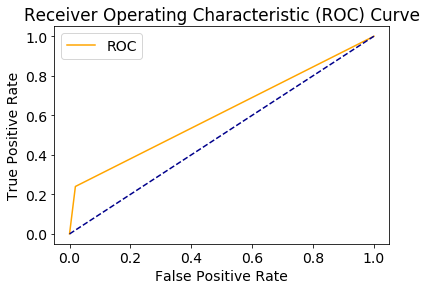

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

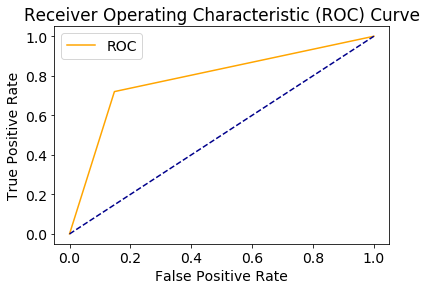

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

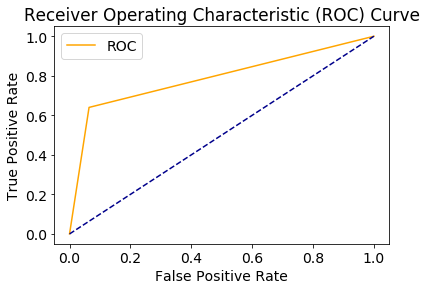

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

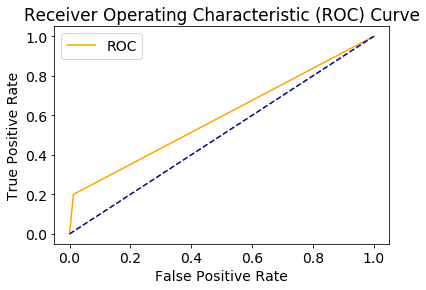

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

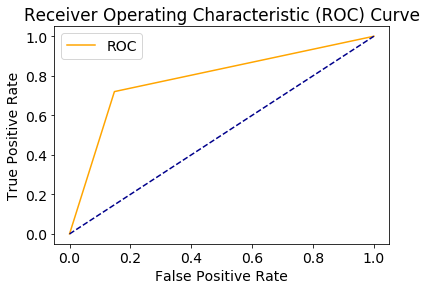

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

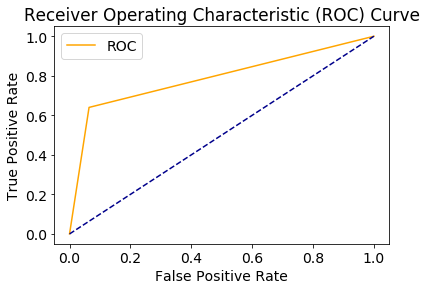

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

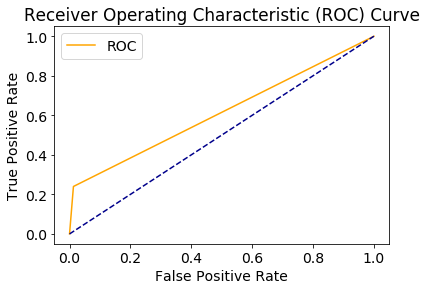

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

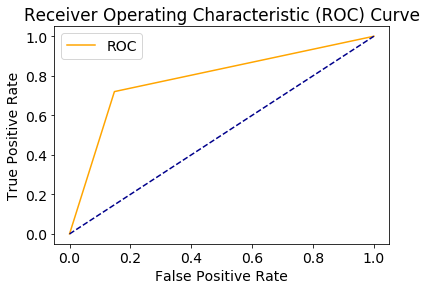

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

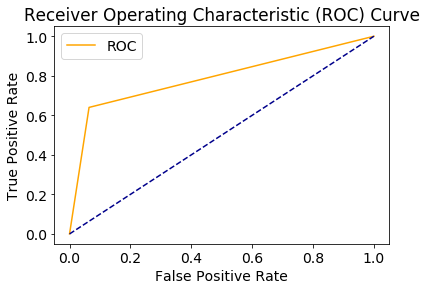

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

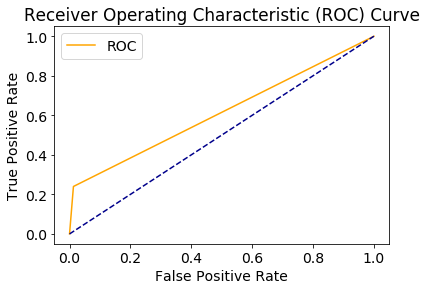

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

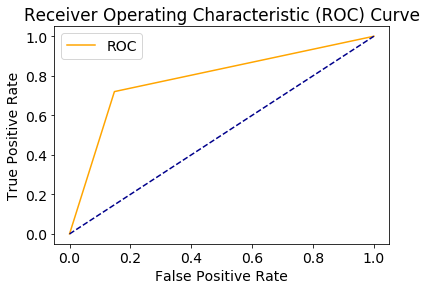

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

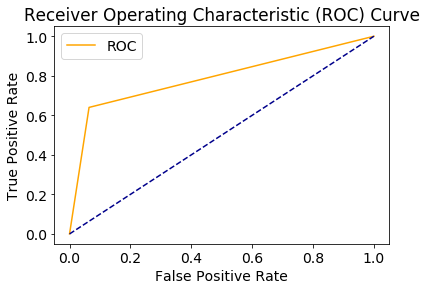

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       156
           1       0.70      0.28      0.40        25

    accuracy                           0.88       181
   macro avg       0.80      0.63      0.67       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

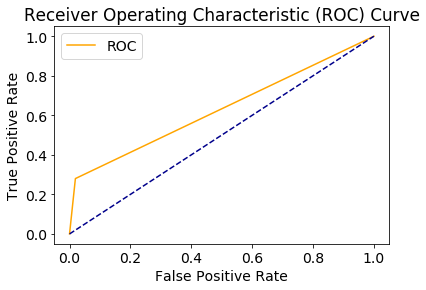

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

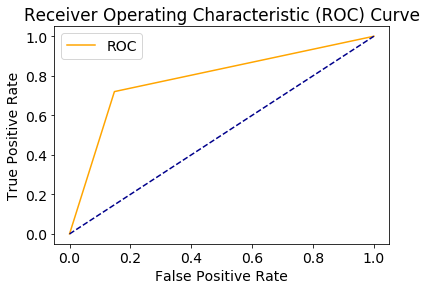

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

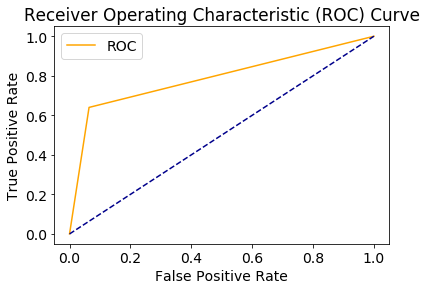

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

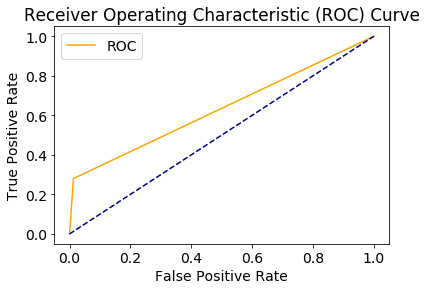

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

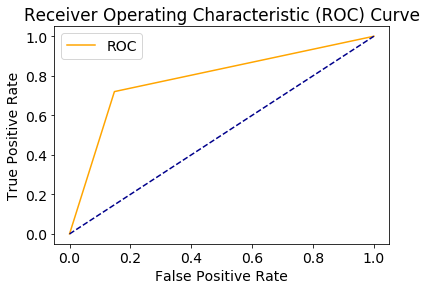

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

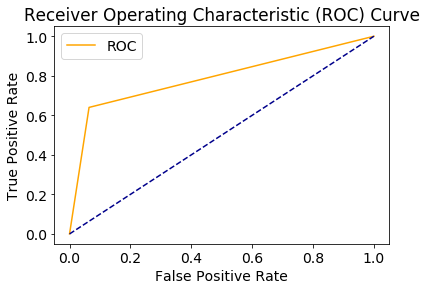

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

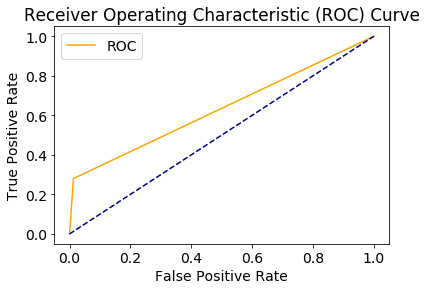

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

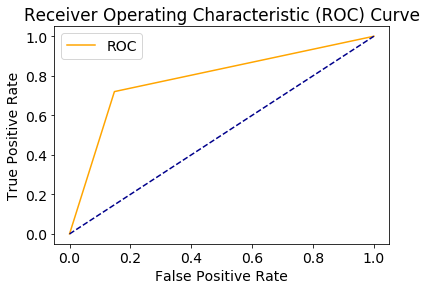

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

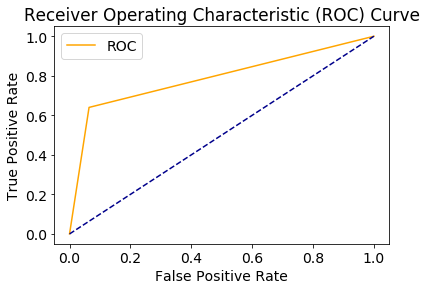

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       156
           1       0.67      0.24      0.35        25

    accuracy                           0.88       181
   macro avg       0.78      0.61      0.64       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

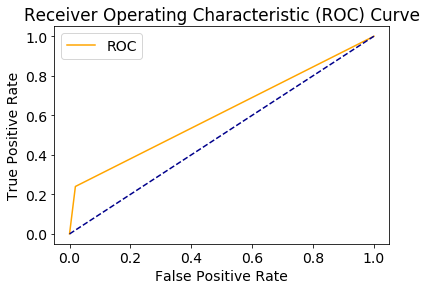

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

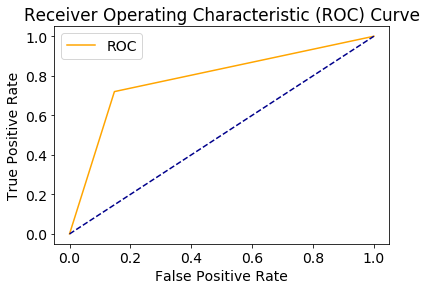

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

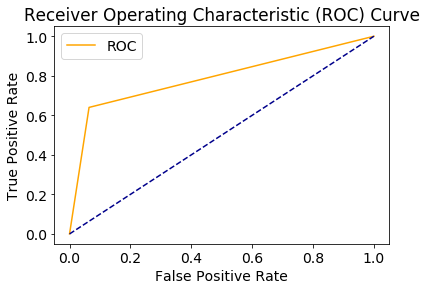

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

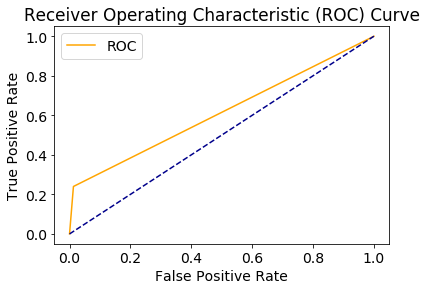

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

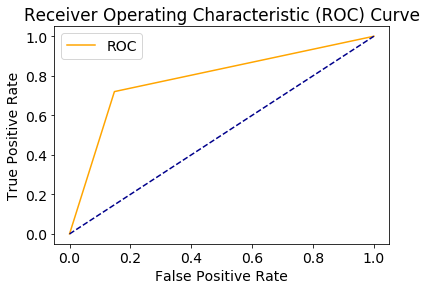

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

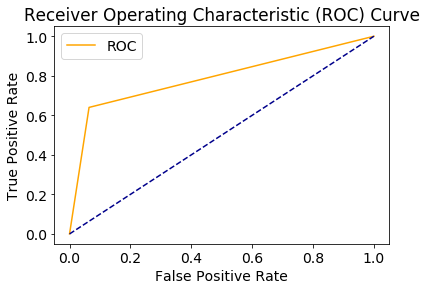

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

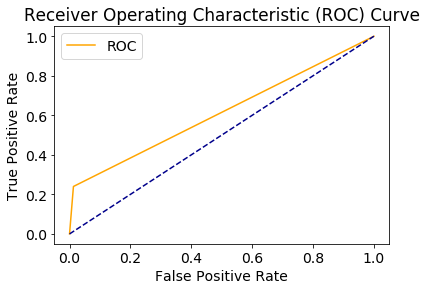

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

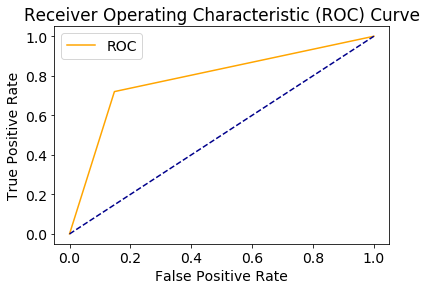

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

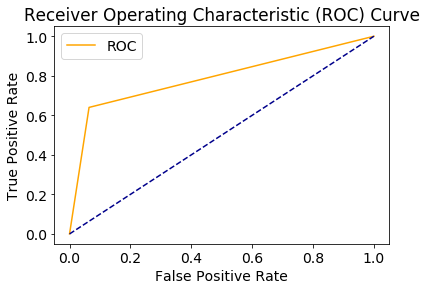

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

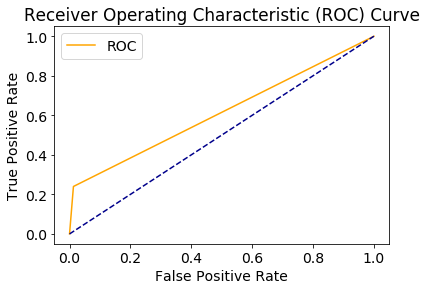

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

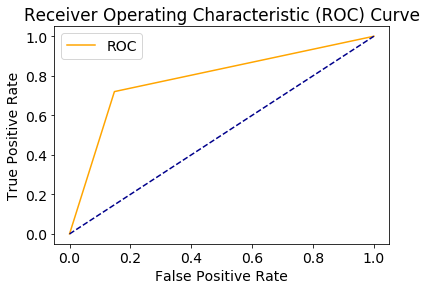

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

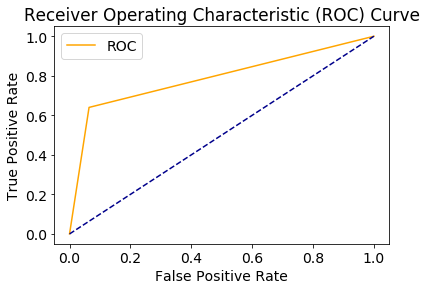

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

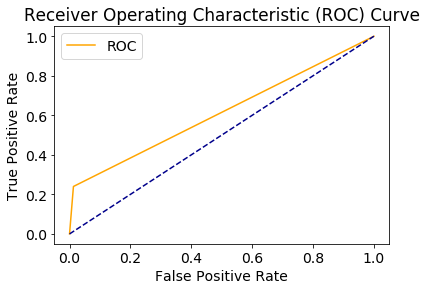

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

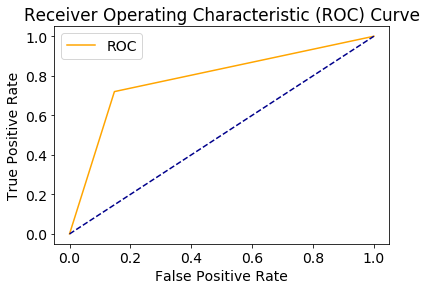

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

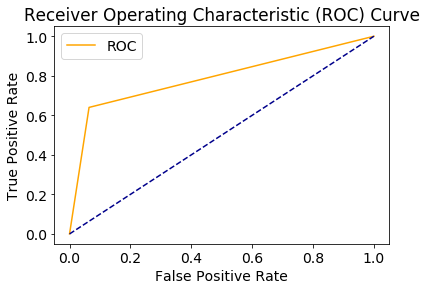

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

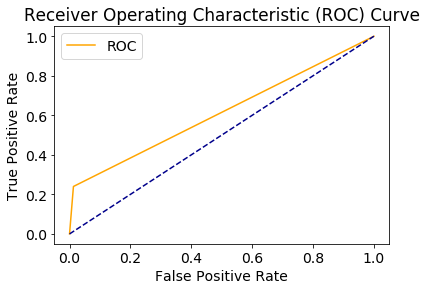

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

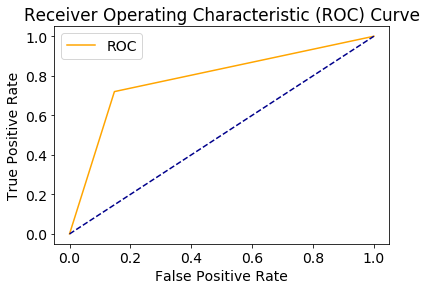

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

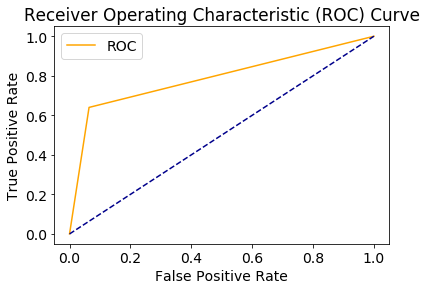

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 86.74
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.60      0.12      0.20        25

    accuracy                           0.87       181
   macro avg       0.74      0.55      0.56       181
weighted avg       0.84      0.87      0.83       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

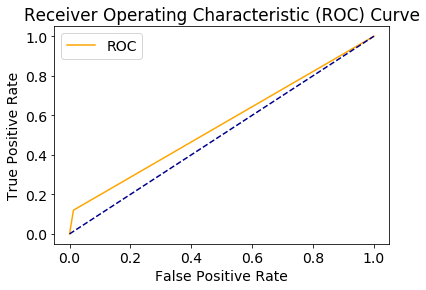

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

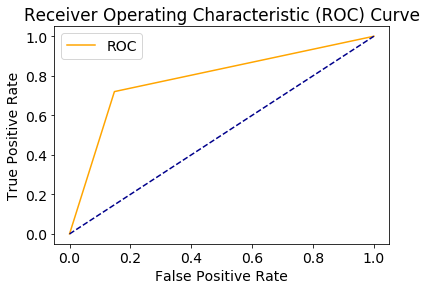

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

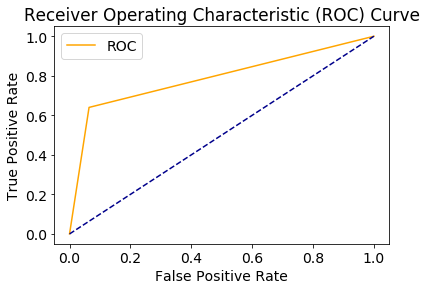

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       156
           1       0.70      0.28      0.40        25

    accuracy                           0.88       181
   macro avg       0.80      0.63      0.67       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

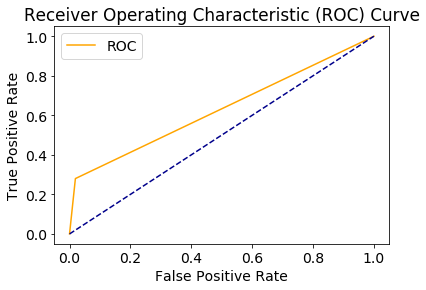

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

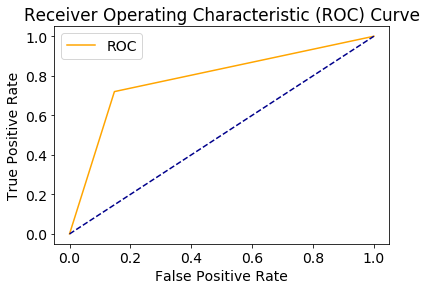

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

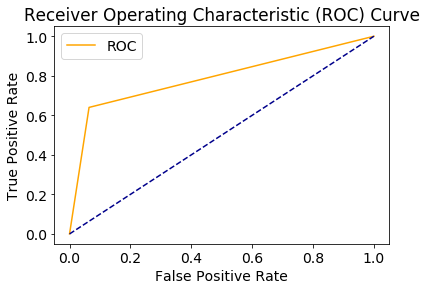

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

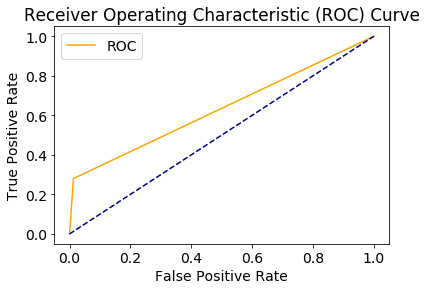

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

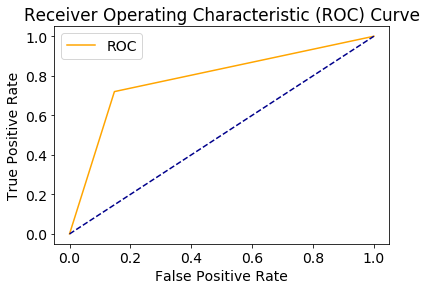

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

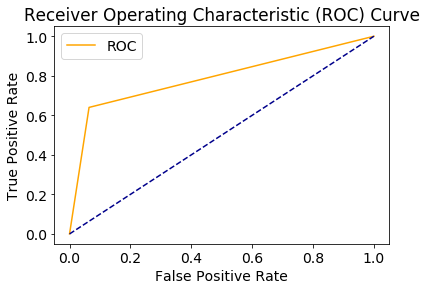

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

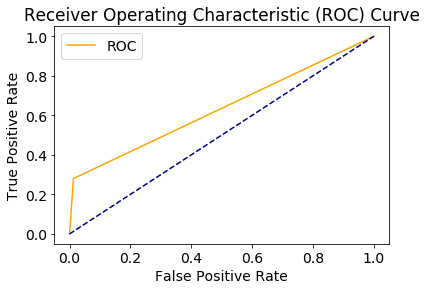

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

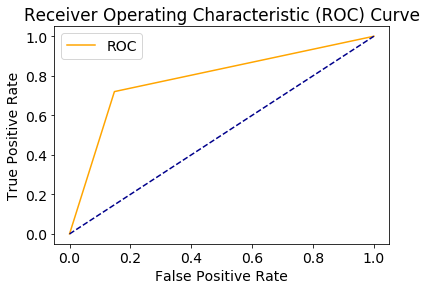

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

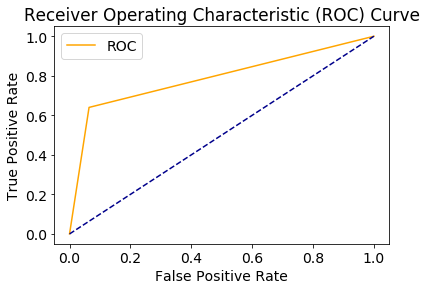

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

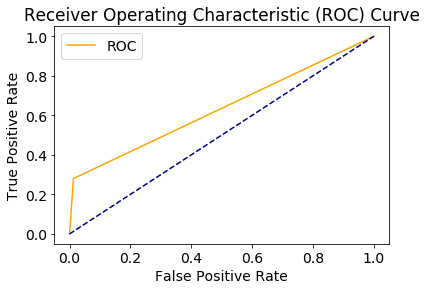

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

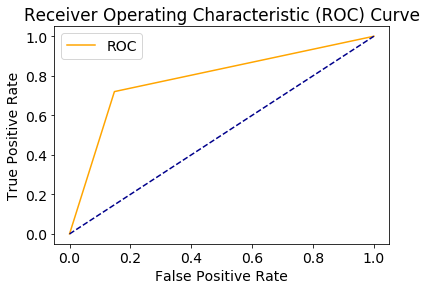

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

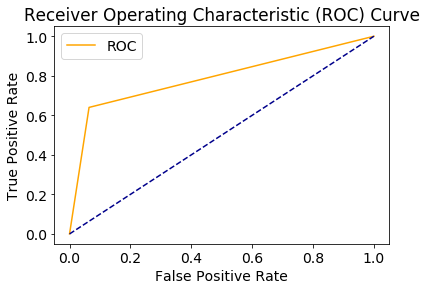

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

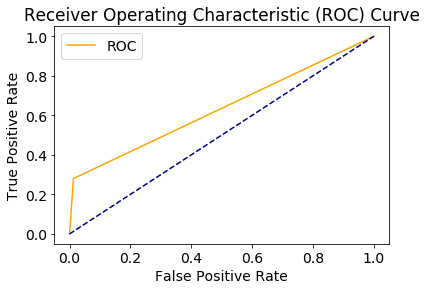

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

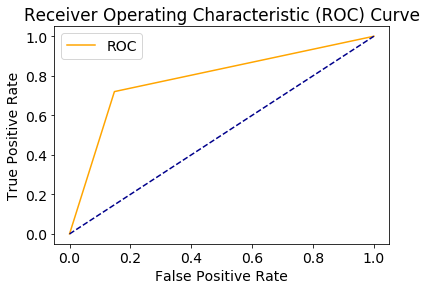

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

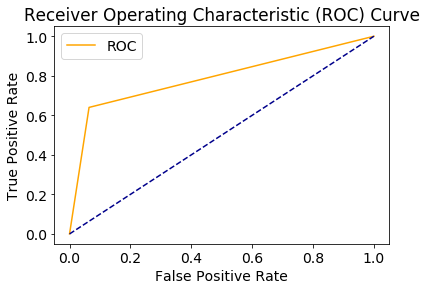

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

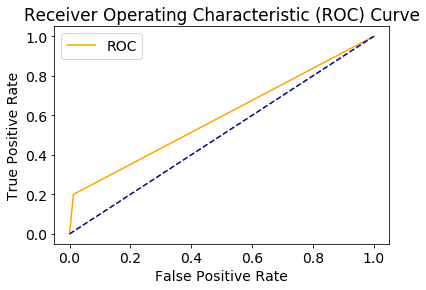

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

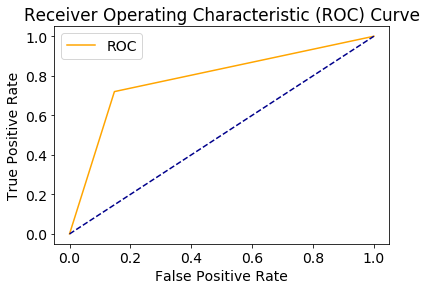

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

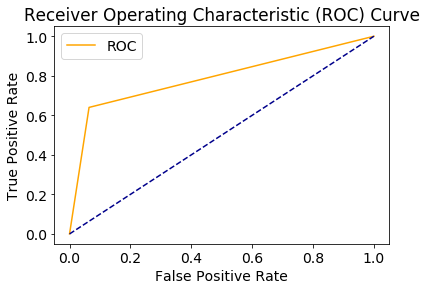

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.80      0.32      0.46        25

    accuracy                           0.90       181
   macro avg       0.85      0.65      0.70       181
weighted avg       0.89      0.90      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

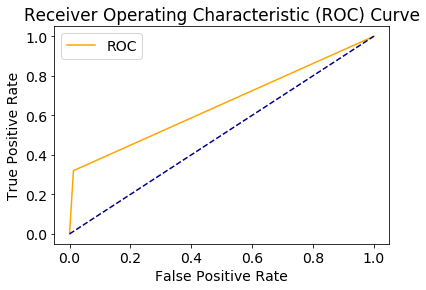

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

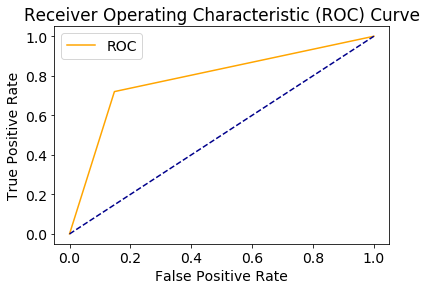

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

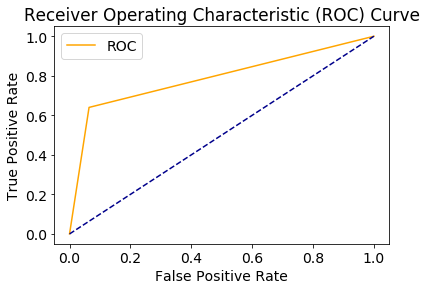

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

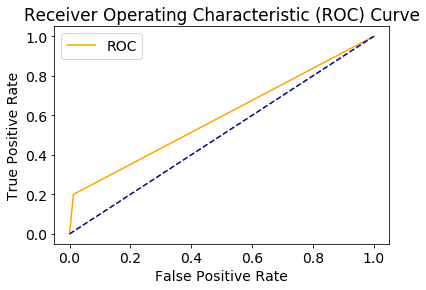

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

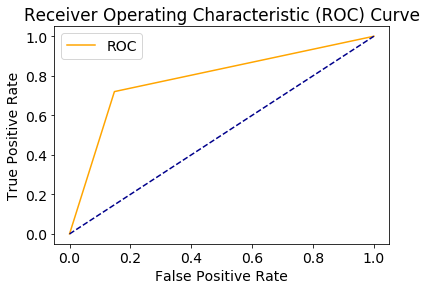

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

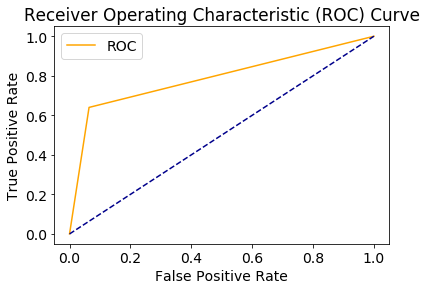

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

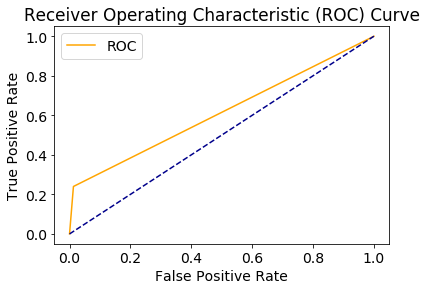

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

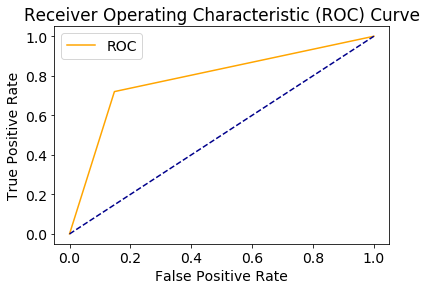

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

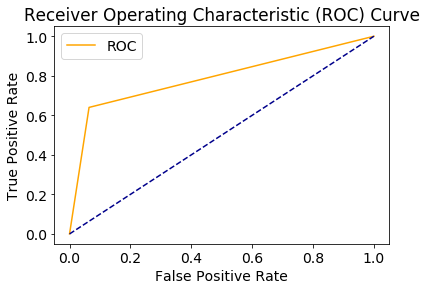

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.67      0.16      0.26        25

    accuracy                           0.87       181
   macro avg       0.77      0.57      0.59       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

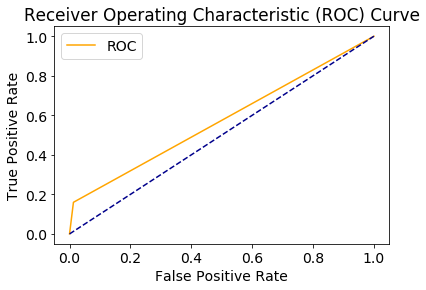

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

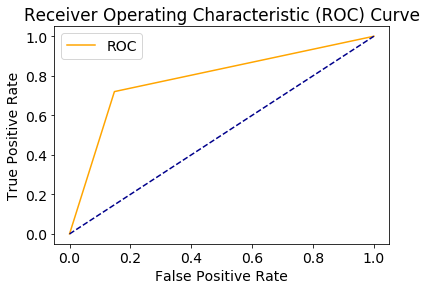

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

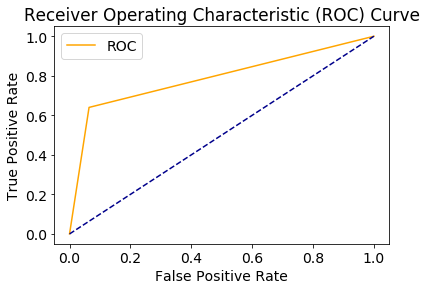

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       156
           1       0.70      0.28      0.40        25

    accuracy                           0.88       181
   macro avg       0.80      0.63      0.67       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

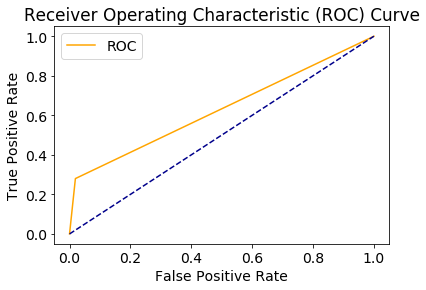

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

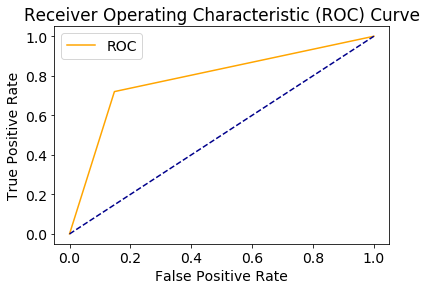

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

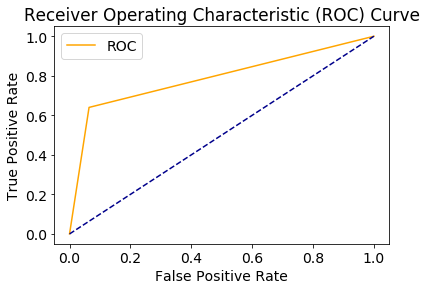

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

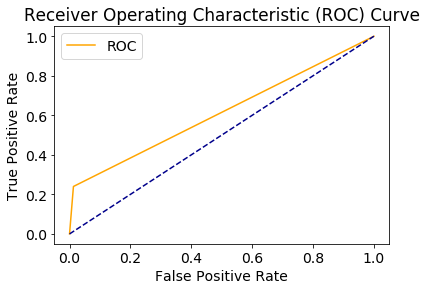

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

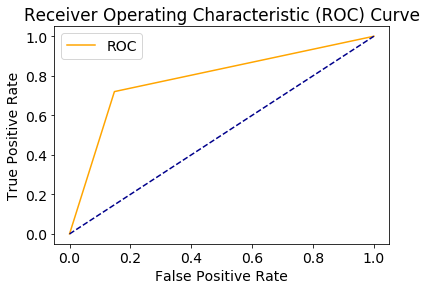

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

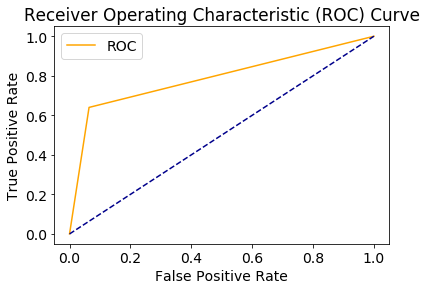

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

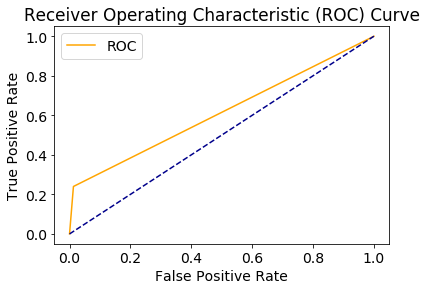

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

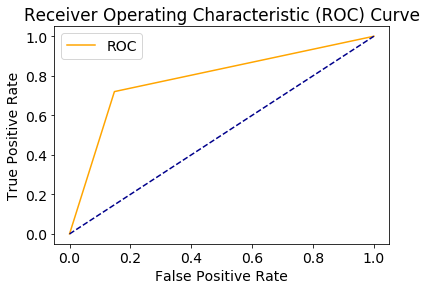

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

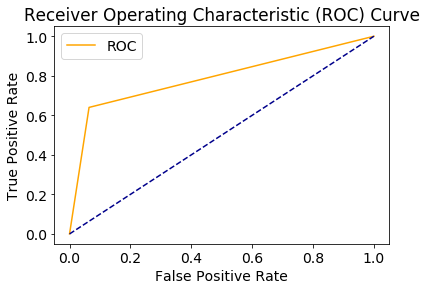

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

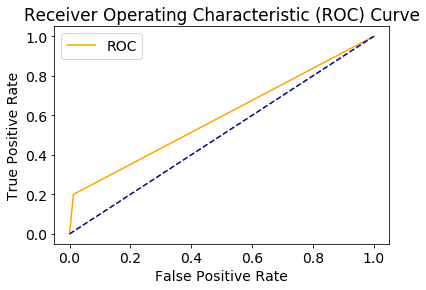

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

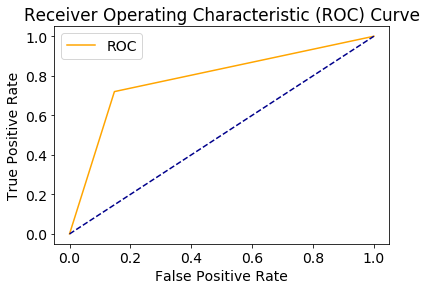

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

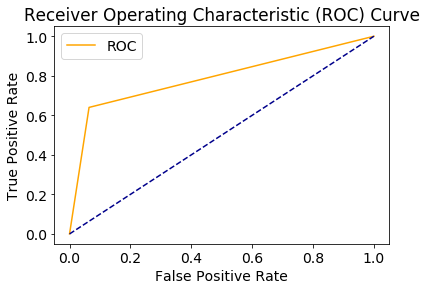

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       156
           1       0.62      0.20      0.30        25

    accuracy                           0.87       181
   macro avg       0.75      0.59      0.62       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

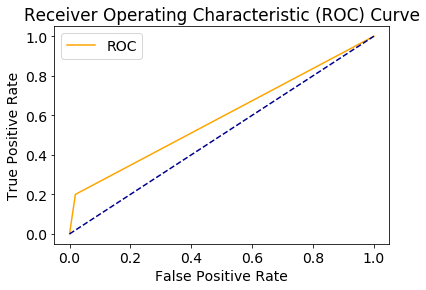

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

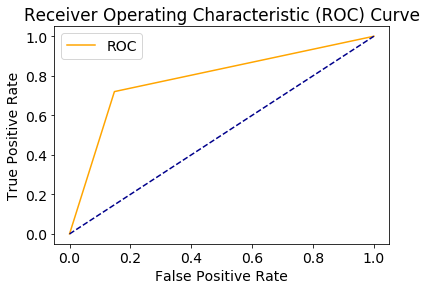

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

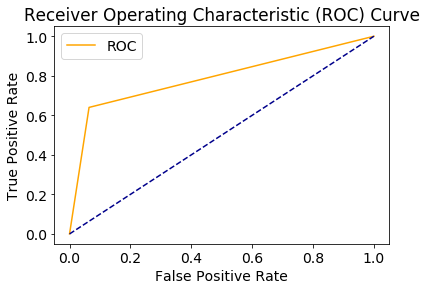

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

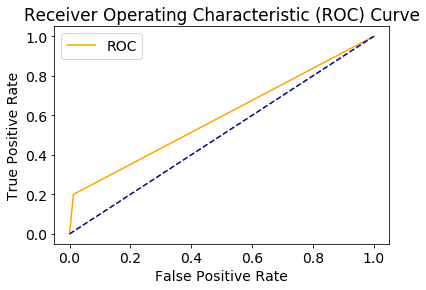

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

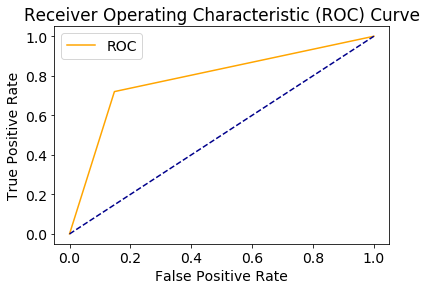

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

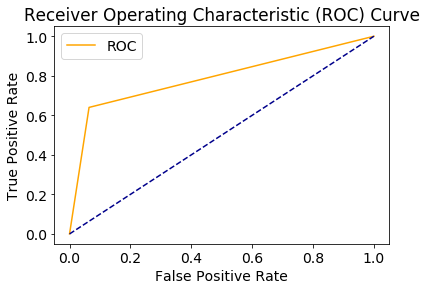

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

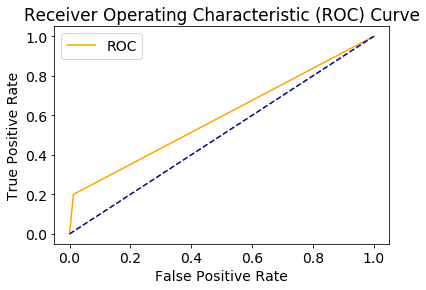

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

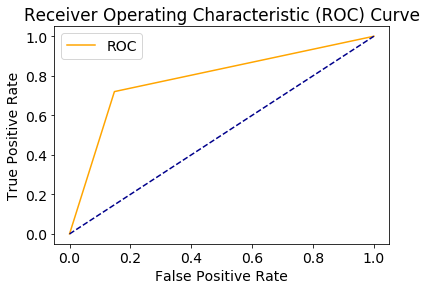

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

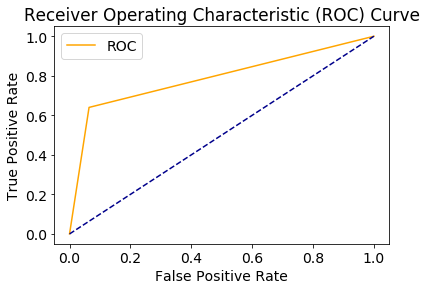

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.86      0.24      0.38        25

    accuracy                           0.89       181
   macro avg       0.87      0.62      0.66       181
weighted avg       0.89      0.89      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

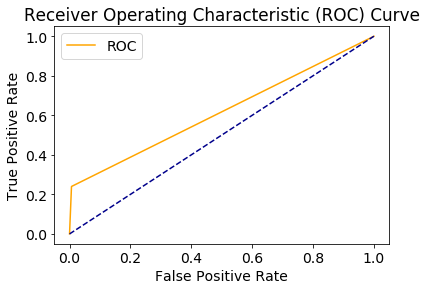

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

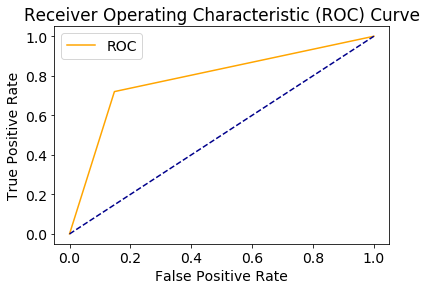

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

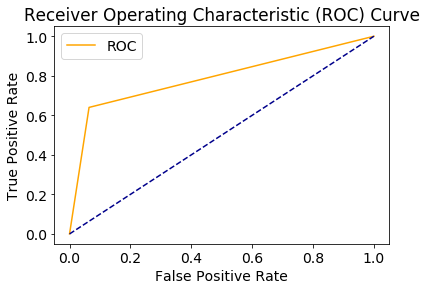

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       156
           1       0.73      0.32      0.44        25

    accuracy                           0.89       181
   macro avg       0.81      0.65      0.69       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

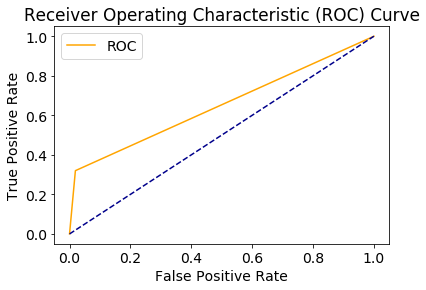

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

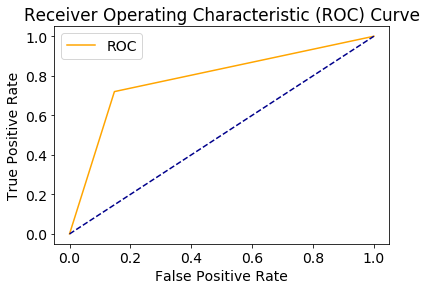

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

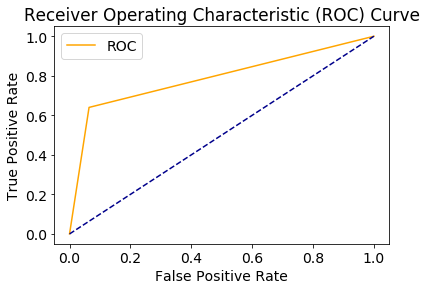

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

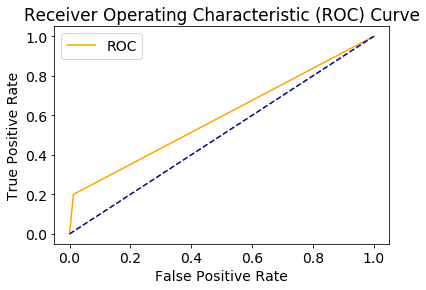

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

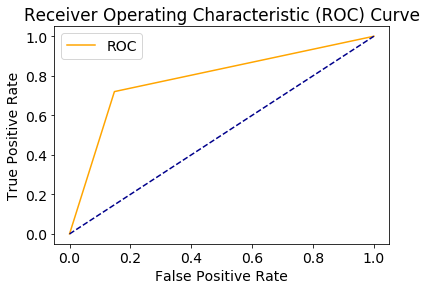

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

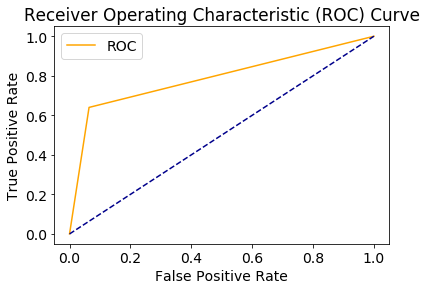

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       156
           1       0.67      0.24      0.35        25

    accuracy                           0.88       181
   macro avg       0.78      0.61      0.64       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

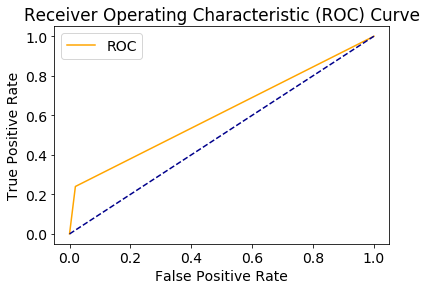

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

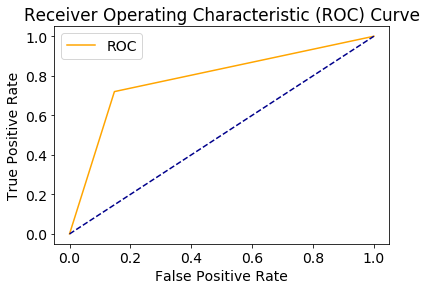

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

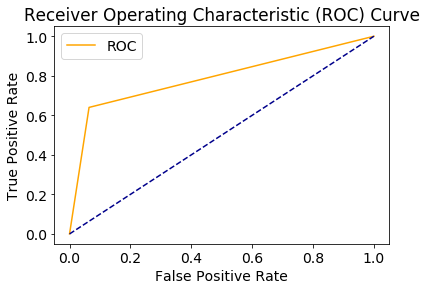

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

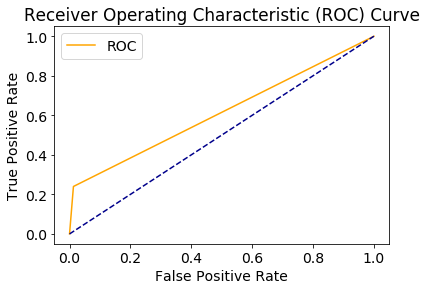

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

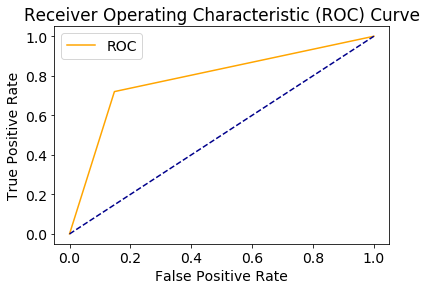

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

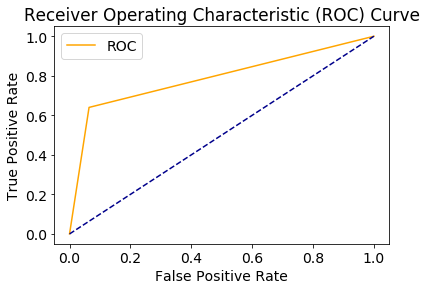

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

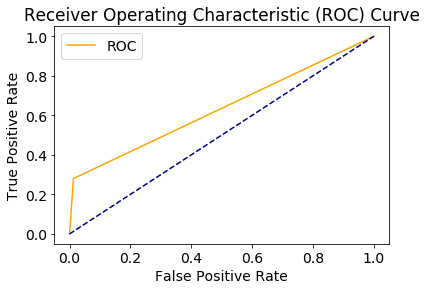

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

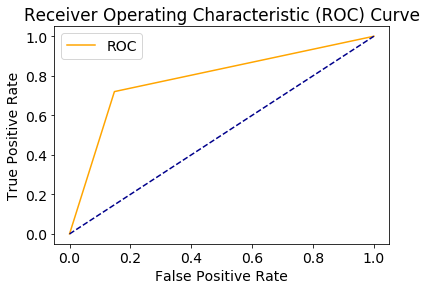

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

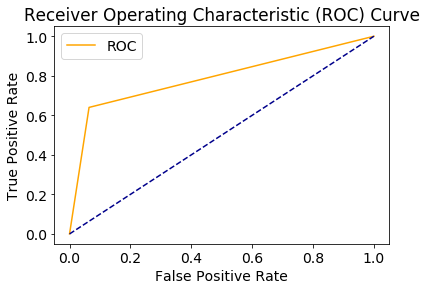

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.86      0.24      0.38        25

    accuracy                           0.89       181
   macro avg       0.87      0.62      0.66       181
weighted avg       0.89      0.89      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

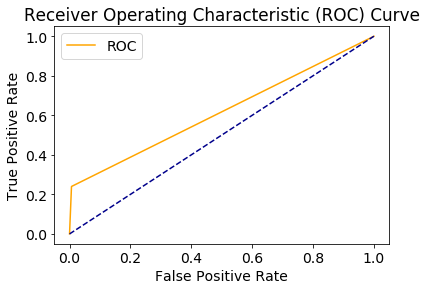

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

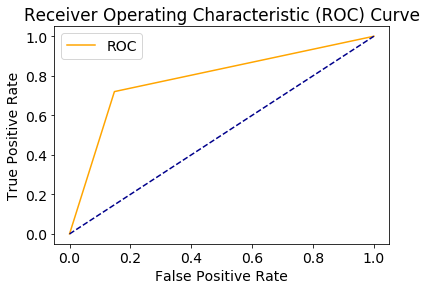

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

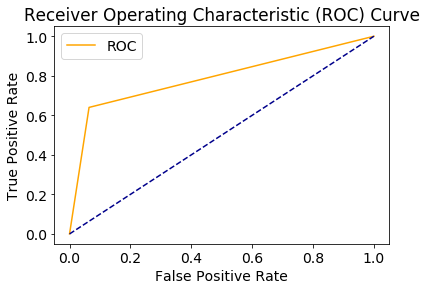

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

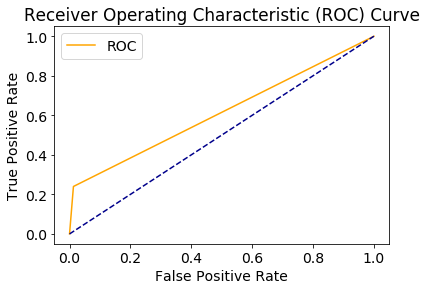

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

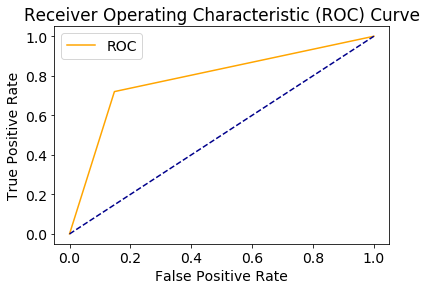

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

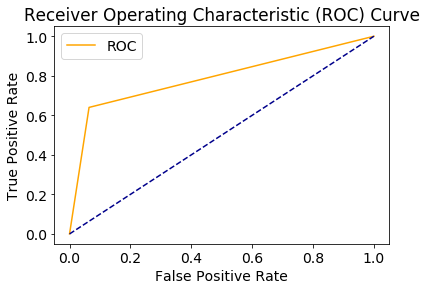

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

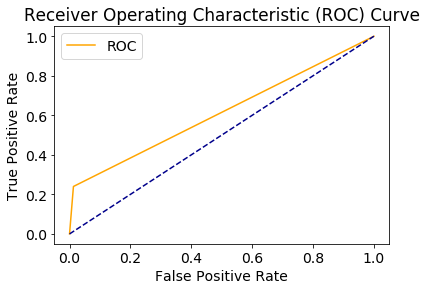

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

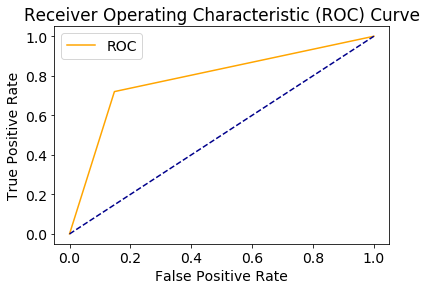

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

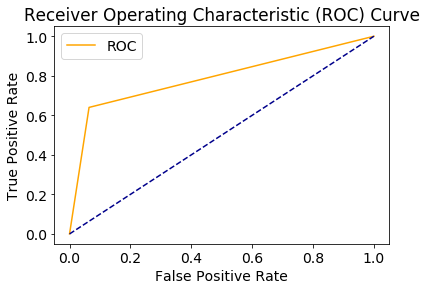

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.53
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       364
           1       1.00      0.97      0.98        58

    accuracy                           1.00       422
   macro avg       1.00      0.98      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  2  56]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       156
           1       0.73      0.32      0.44        25

    accuracy                           0.89       181
   macro avg       0.81      0.65      0.69       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

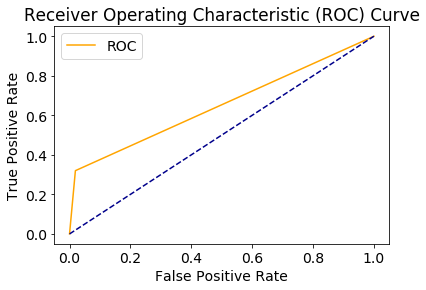

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

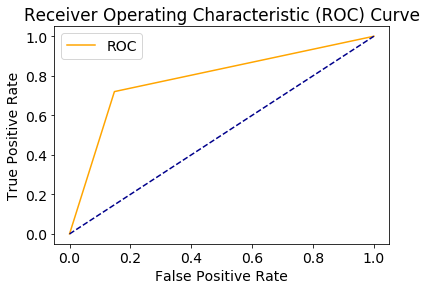

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

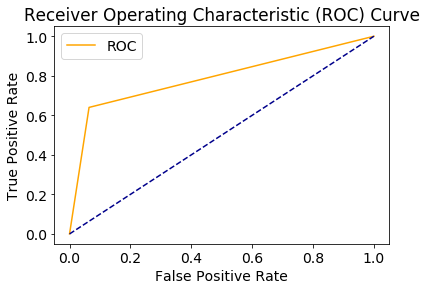

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

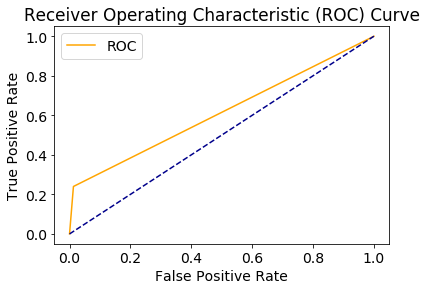

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

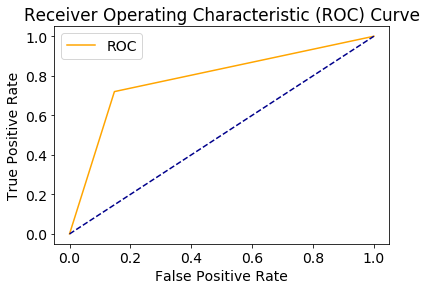

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

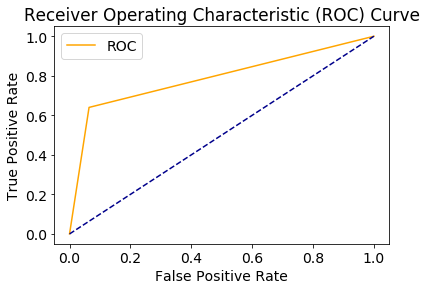

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       156
           1       0.62      0.20      0.30        25

    accuracy                           0.87       181
   macro avg       0.75      0.59      0.62       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

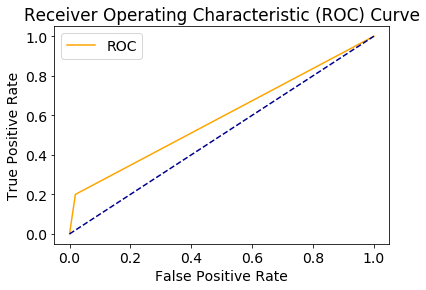

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

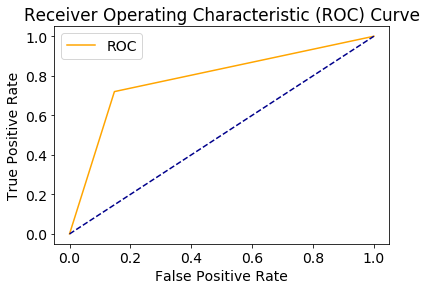

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

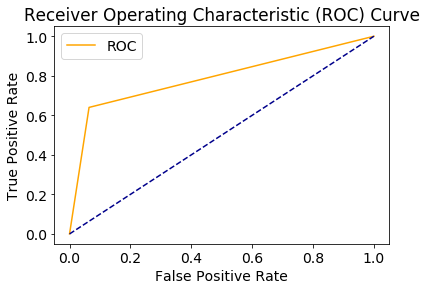

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

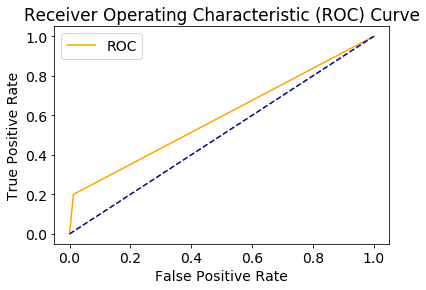

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

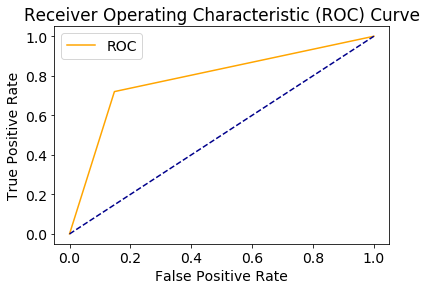

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

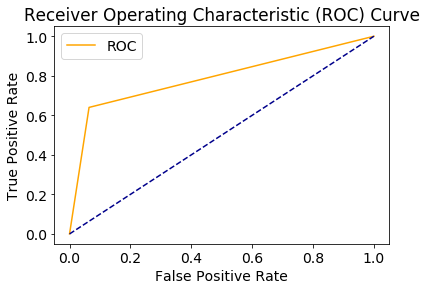

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

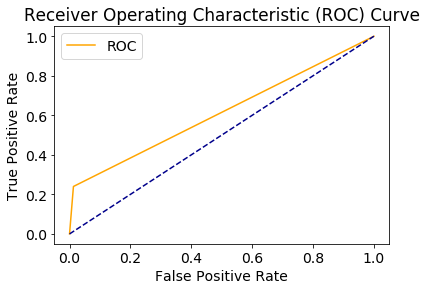

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

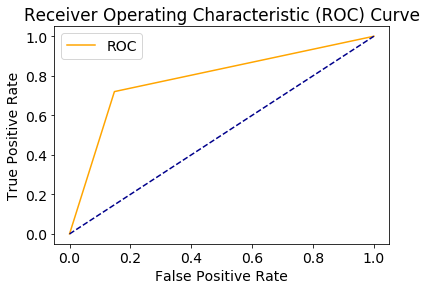

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

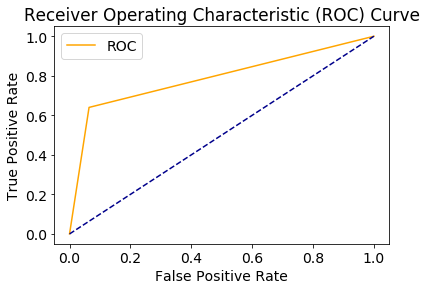

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       156
           1       0.70      0.28      0.40        25

    accuracy                           0.88       181
   macro avg       0.80      0.63      0.67       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

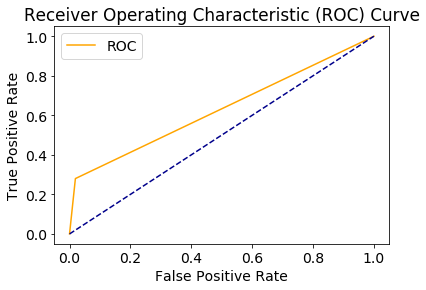

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

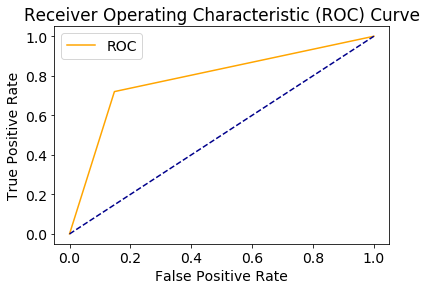

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

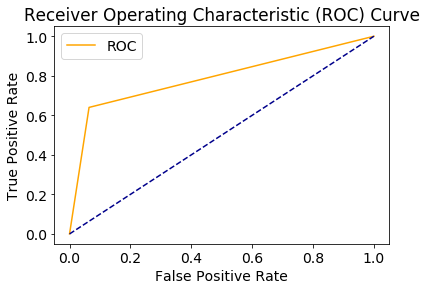

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

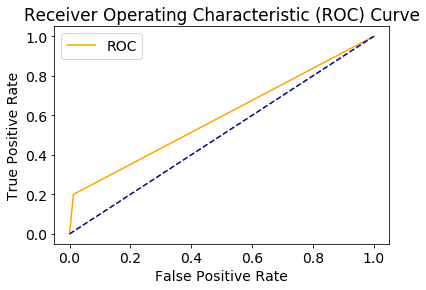

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

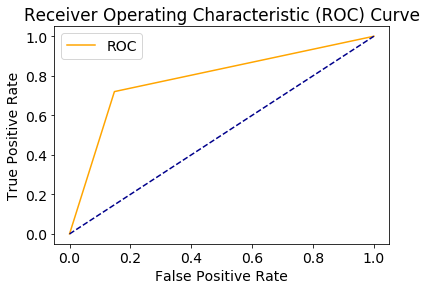

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

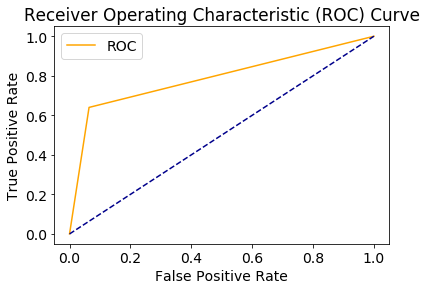

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

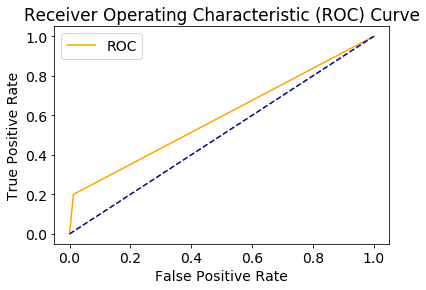

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

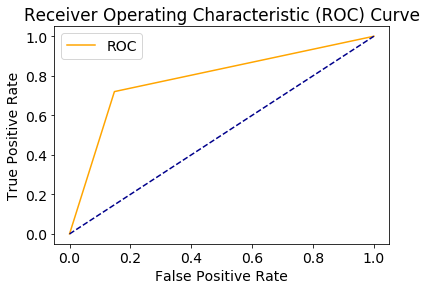

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

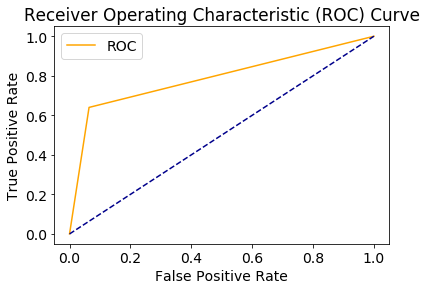

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       156
           1       0.62      0.20      0.30        25

    accuracy                           0.87       181
   macro avg       0.75      0.59      0.62       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

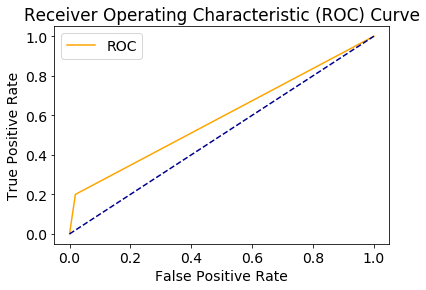

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

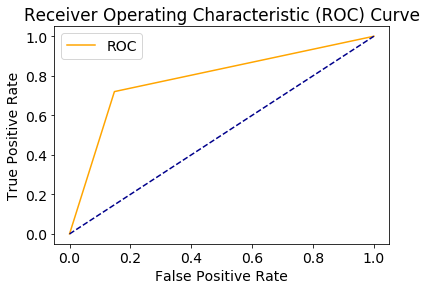

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

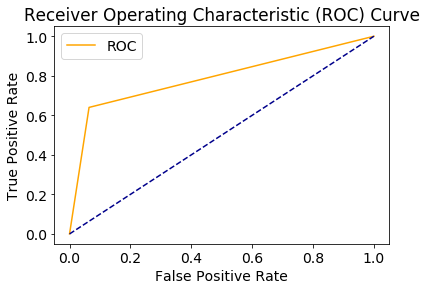

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

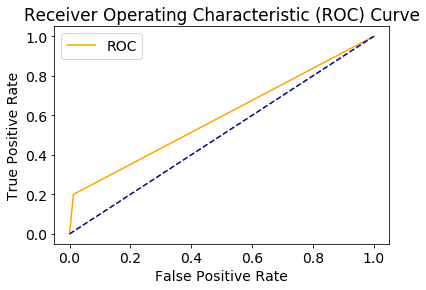

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

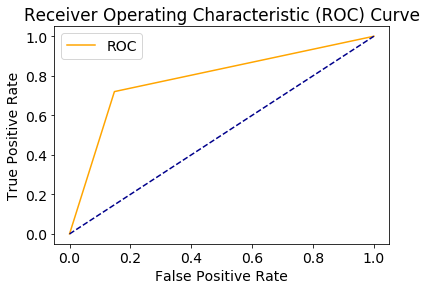

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

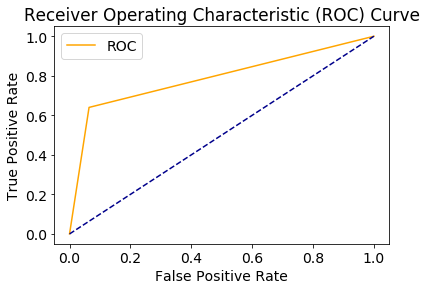

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

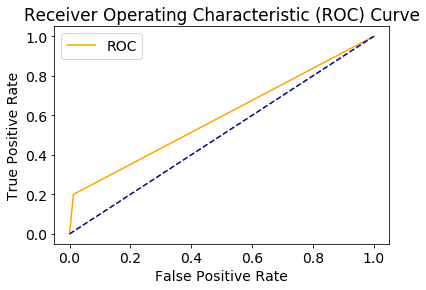

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

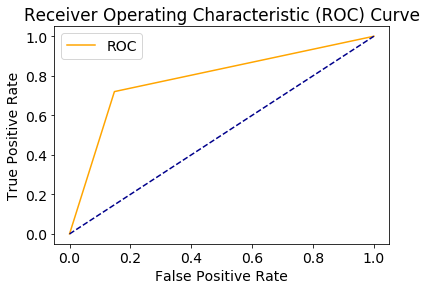

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

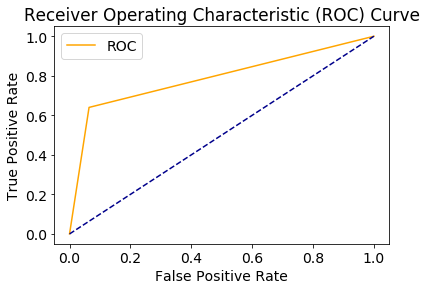

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       156
           1       0.67      0.24      0.35        25

    accuracy                           0.88       181
   macro avg       0.78      0.61      0.64       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

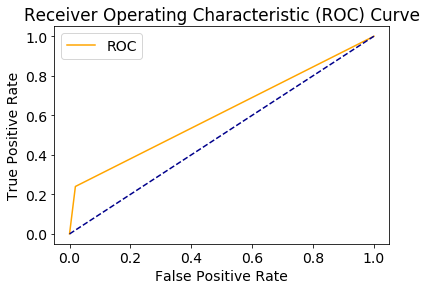

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

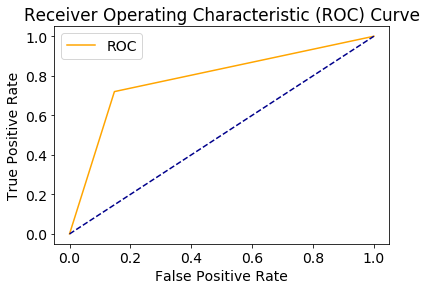

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

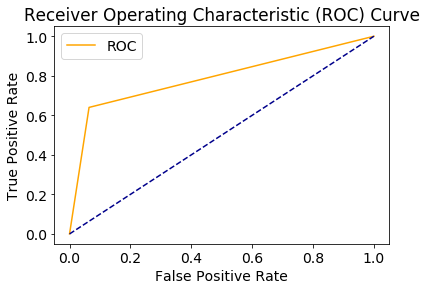

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

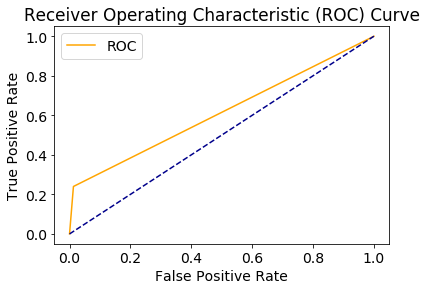

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

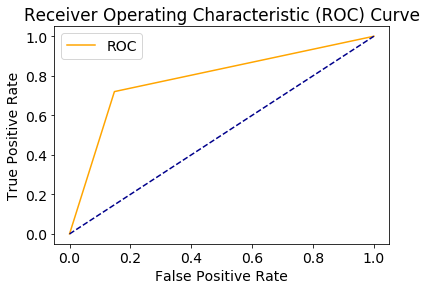

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

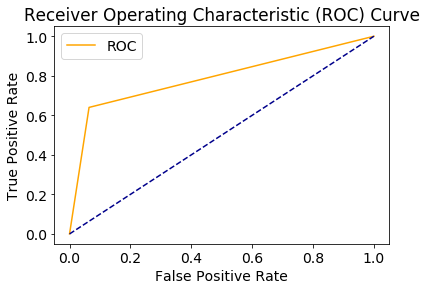

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.67      0.16      0.26        25

    accuracy                           0.87       181
   macro avg       0.77      0.57      0.59       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

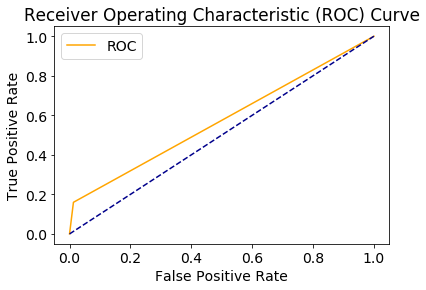

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

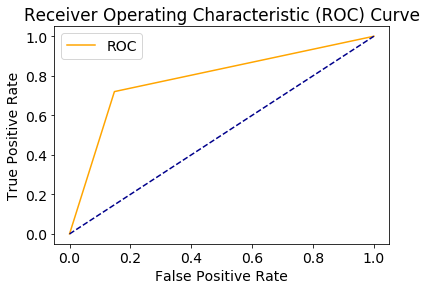

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

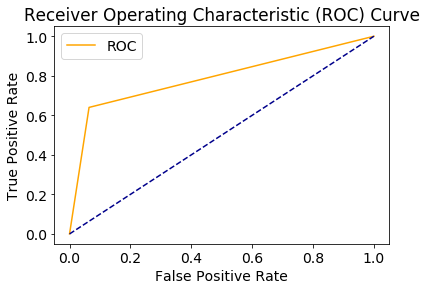

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

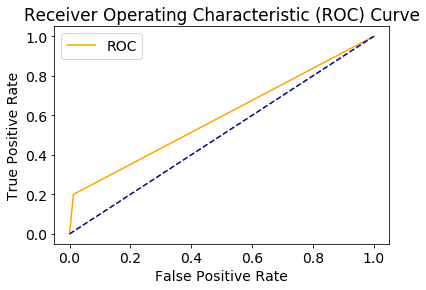

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

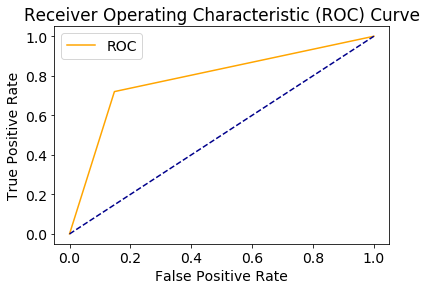

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

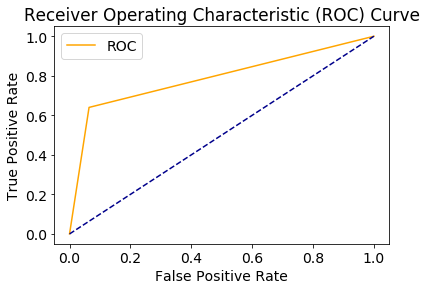

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.67      0.16      0.26        25

    accuracy                           0.87       181
   macro avg       0.77      0.57      0.59       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

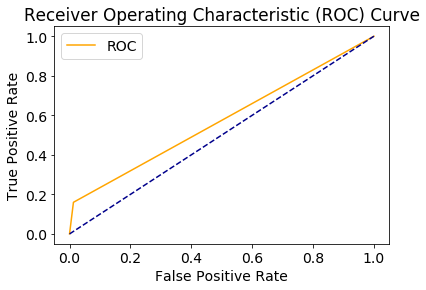

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

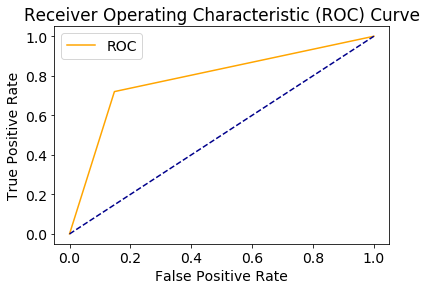

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

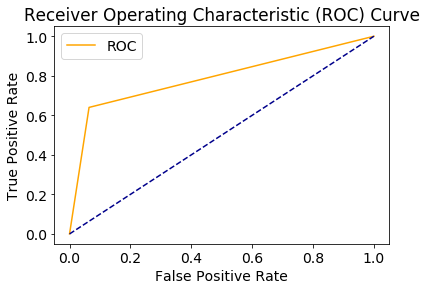

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       156
           1       0.67      0.24      0.35        25

    accuracy                           0.88       181
   macro avg       0.78      0.61      0.64       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

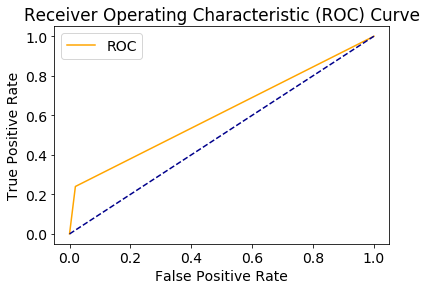

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

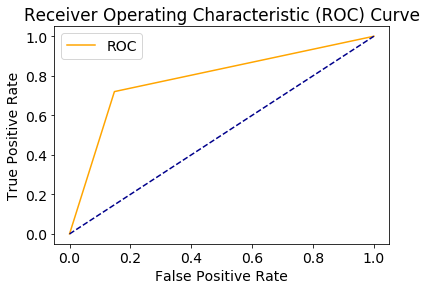

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

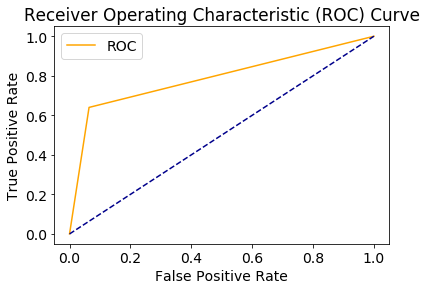

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.86      0.24      0.38        25

    accuracy                           0.89       181
   macro avg       0.87      0.62      0.66       181
weighted avg       0.89      0.89      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

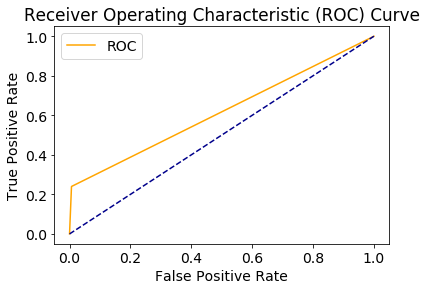

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

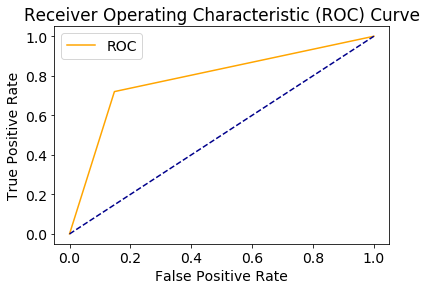

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

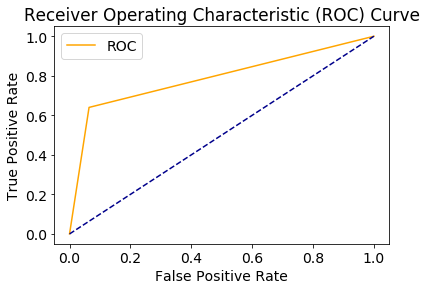

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

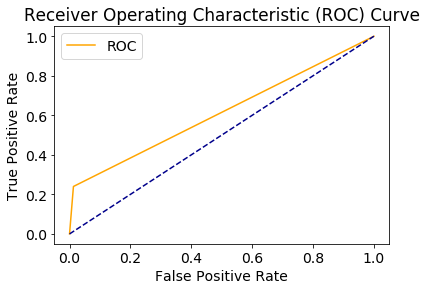

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

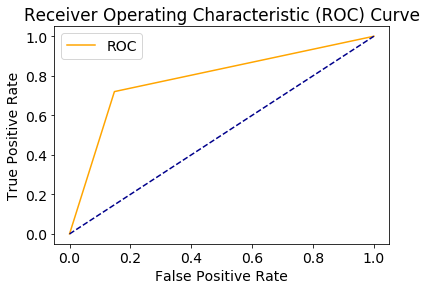

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

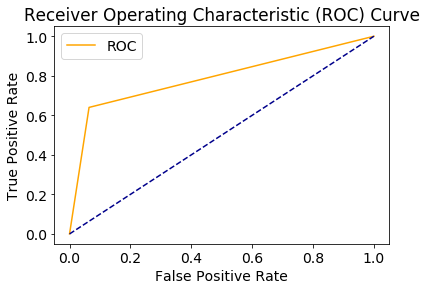

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 86.74
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       156
           1       0.57      0.16      0.25        25

    accuracy                           0.87       181
   macro avg       0.73      0.57      0.59       181
weighted avg       0.84      0.87      0.83       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

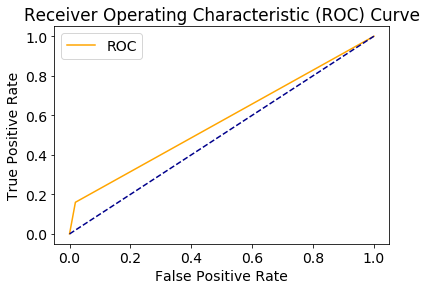

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

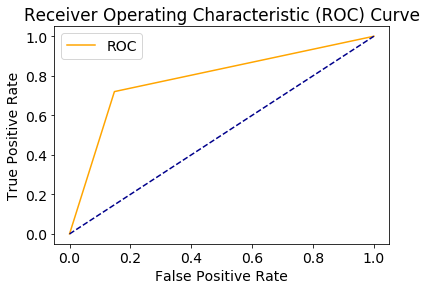

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

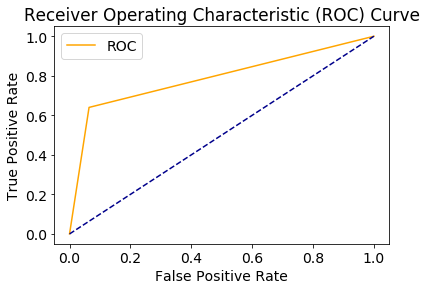

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

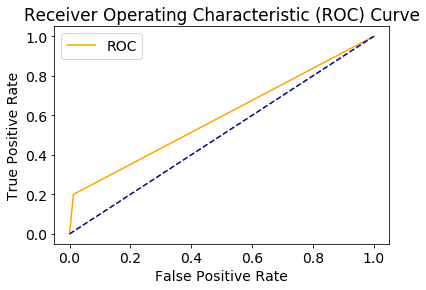

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

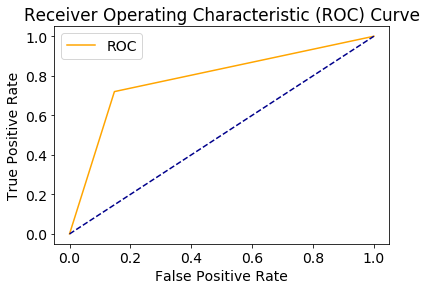

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

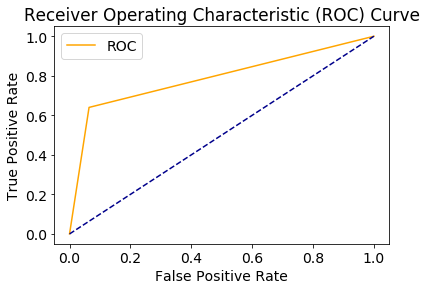

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

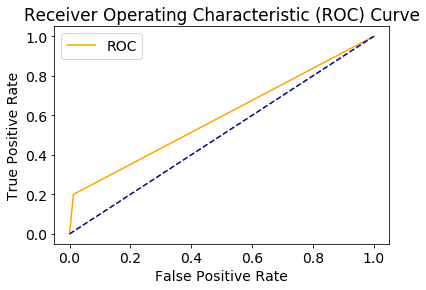

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

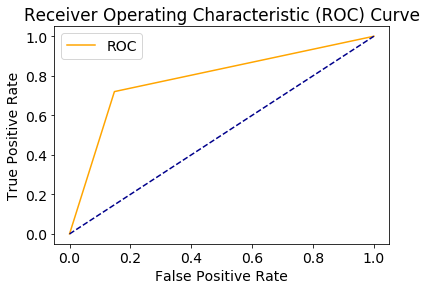

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

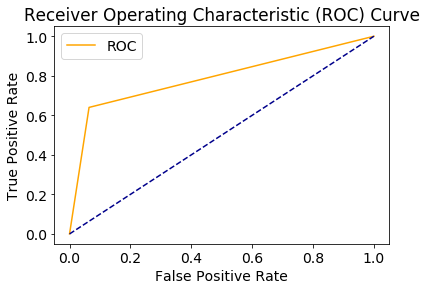

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

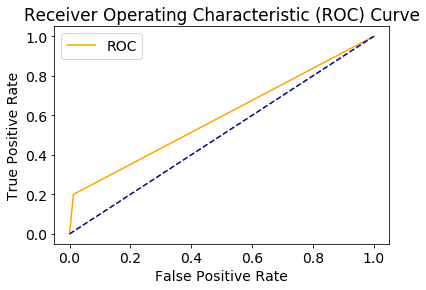

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

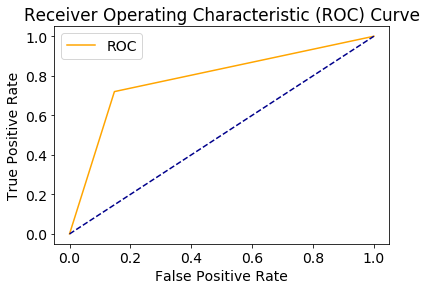

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

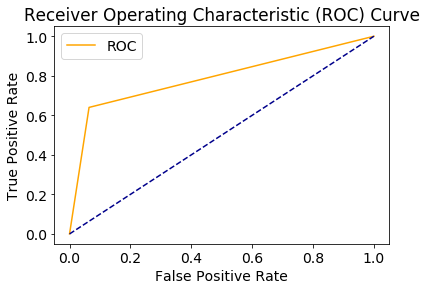

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

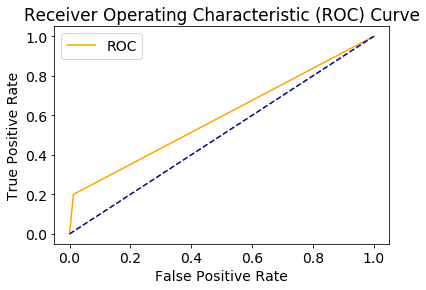

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

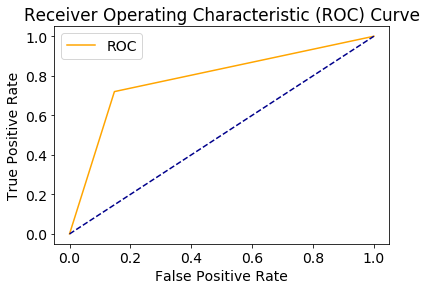

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

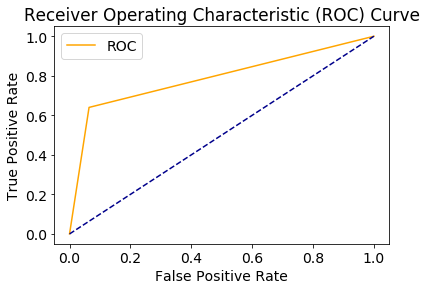

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

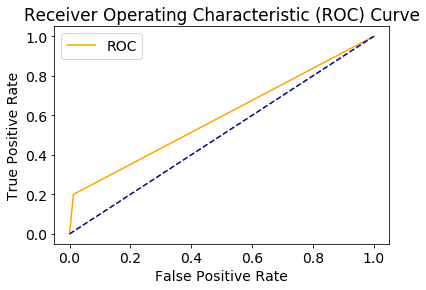

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

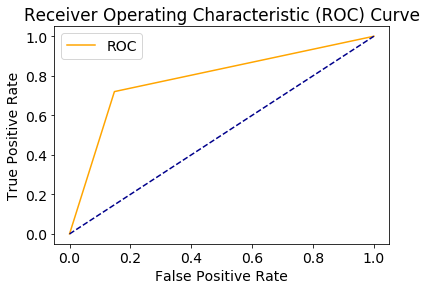

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

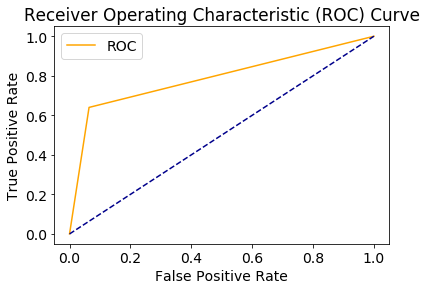

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

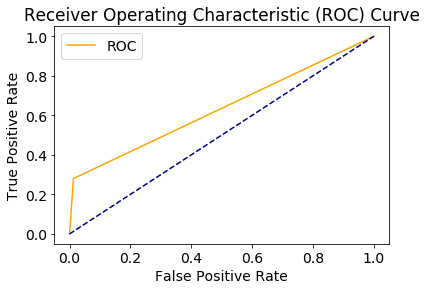

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

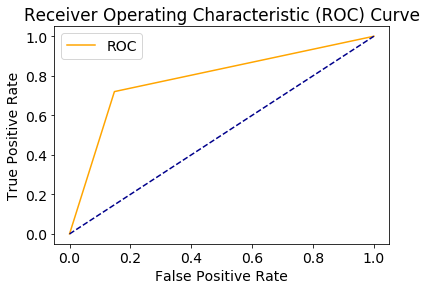

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

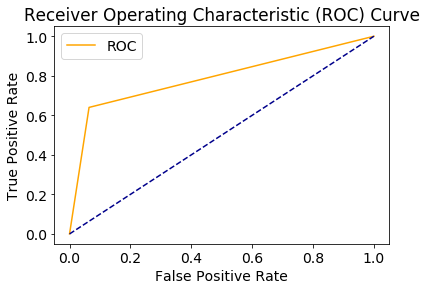

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

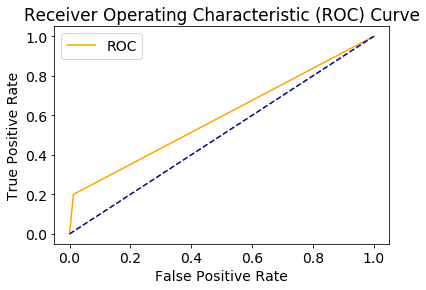

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

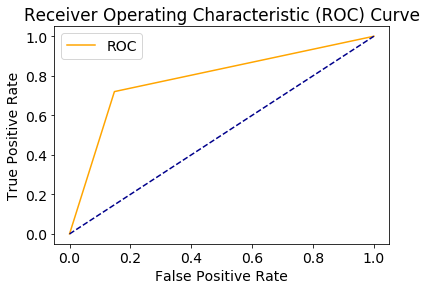

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

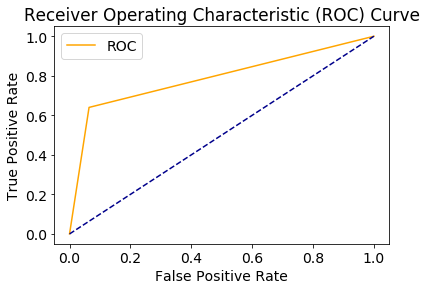

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

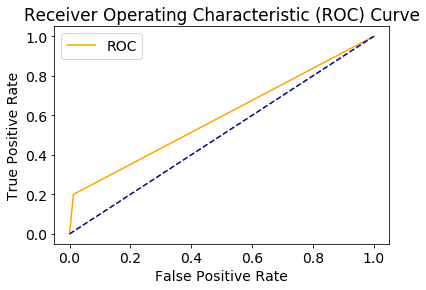

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

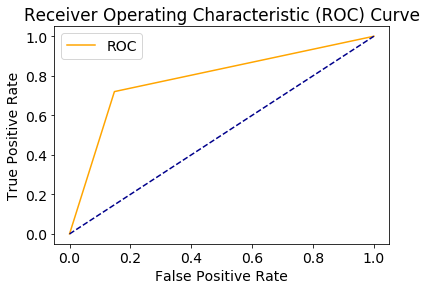

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

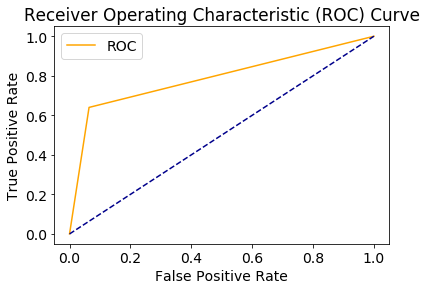

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.80      0.32      0.46        25

    accuracy                           0.90       181
   macro avg       0.85      0.65      0.70       181
weighted avg       0.89      0.90      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

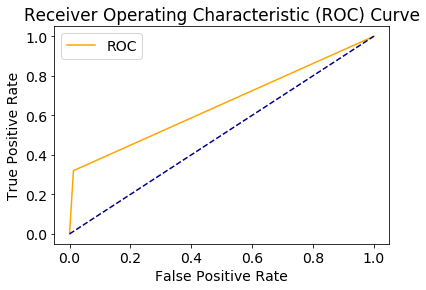

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

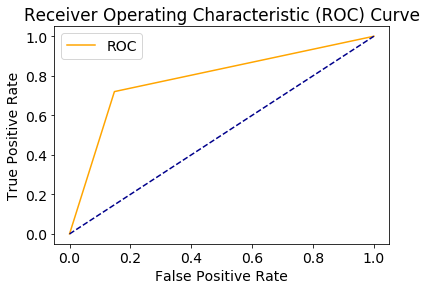

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

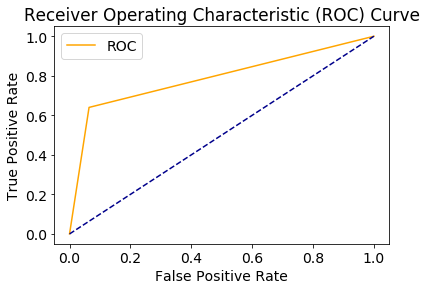

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 86.74
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.60      0.12      0.20        25

    accuracy                           0.87       181
   macro avg       0.74      0.55      0.56       181
weighted avg       0.84      0.87      0.83       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

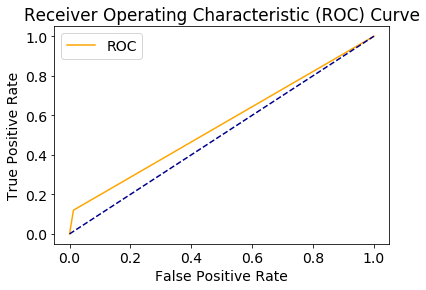

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

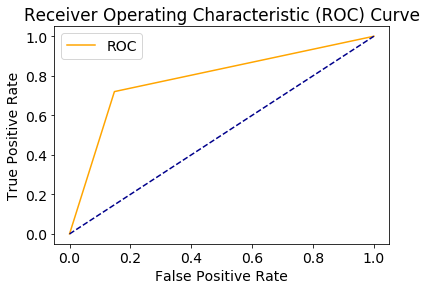

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

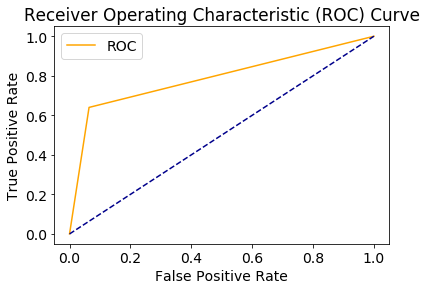

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

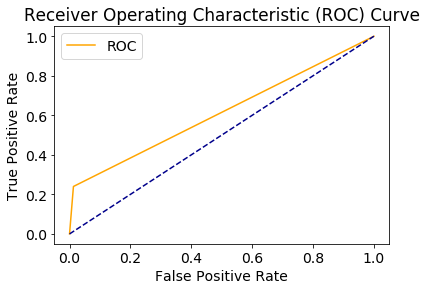

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

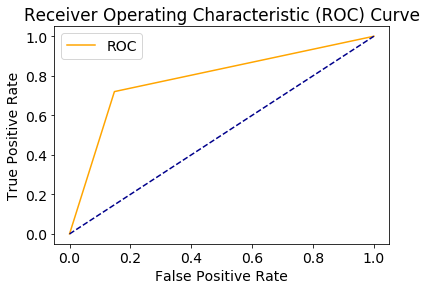

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

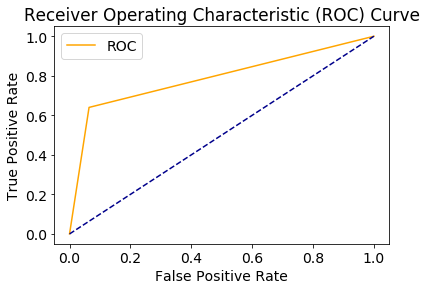

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

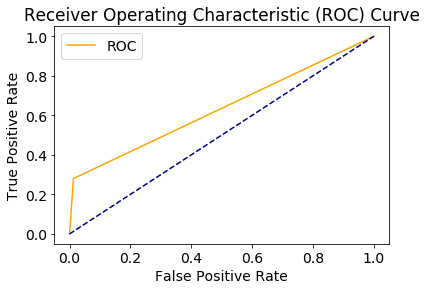

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

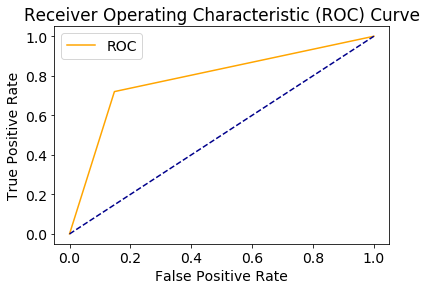

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

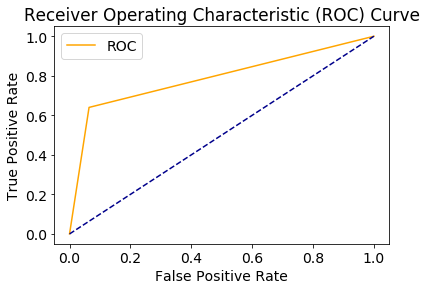

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       156
           1       0.67      0.24      0.35        25

    accuracy                           0.88       181
   macro avg       0.78      0.61      0.64       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

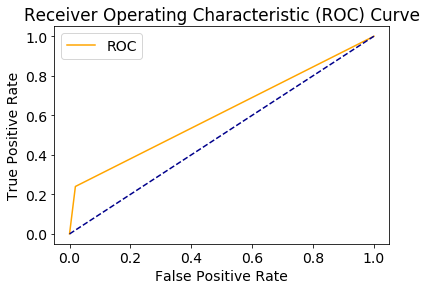

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

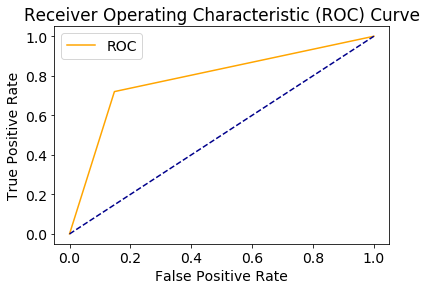

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

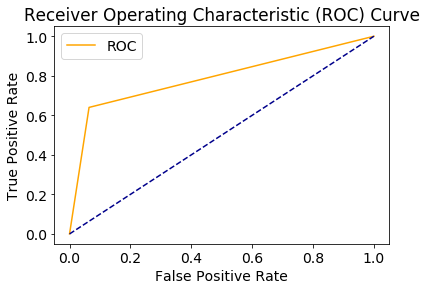

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.67      0.16      0.26        25

    accuracy                           0.87       181
   macro avg       0.77      0.57      0.59       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

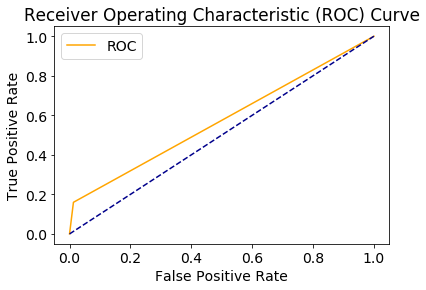

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

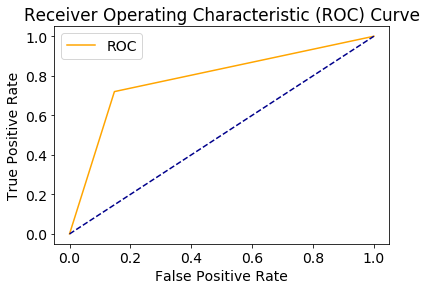

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

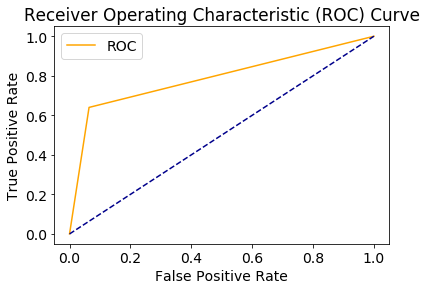

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       156
           1       0.67      0.24      0.35        25

    accuracy                           0.88       181
   macro avg       0.78      0.61      0.64       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

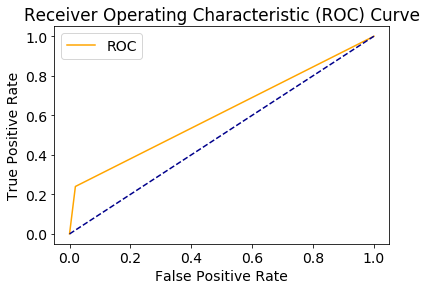

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

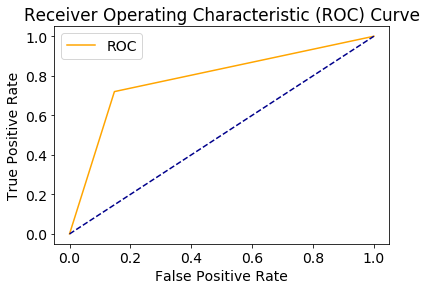

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

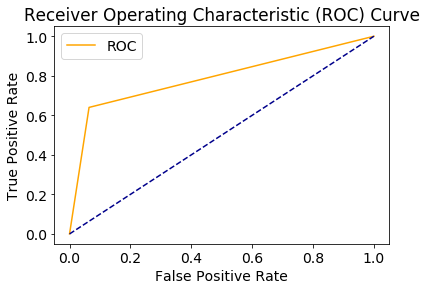

===============Randon Forest Results====================

-- Training data --
Accuracy: 99.76
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99        58

    accuracy                           1.00       422
   macro avg       1.00      0.99      0.99       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  1  57]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in the

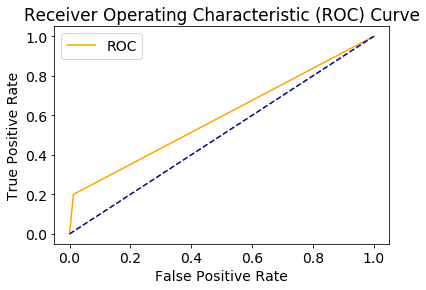

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

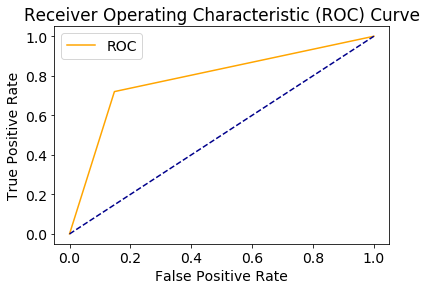

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

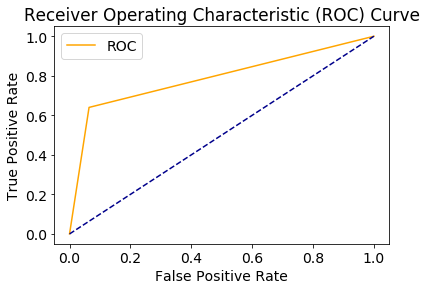

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       156
           1       0.67      0.24      0.35        25

    accuracy                           0.88       181
   macro avg       0.78      0.61      0.64       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

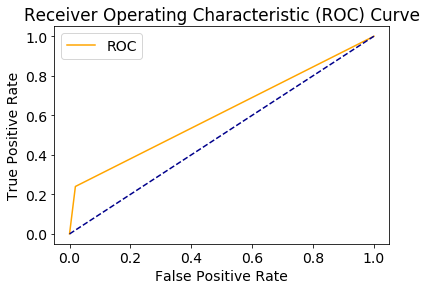

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

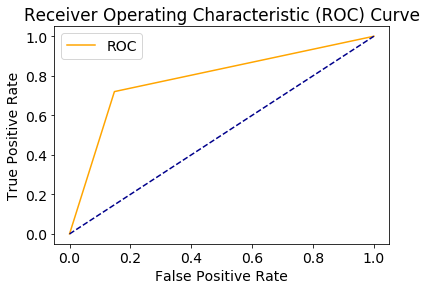

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

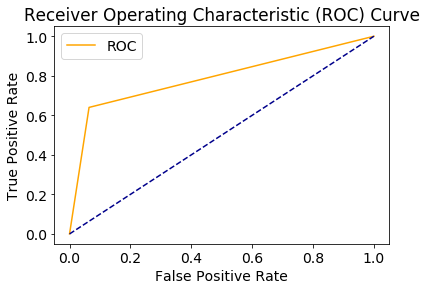

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

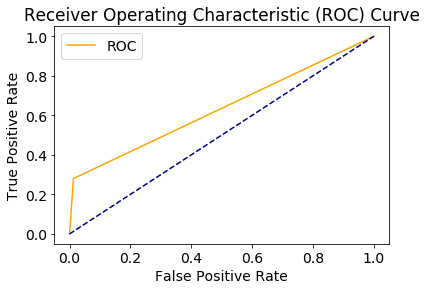

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

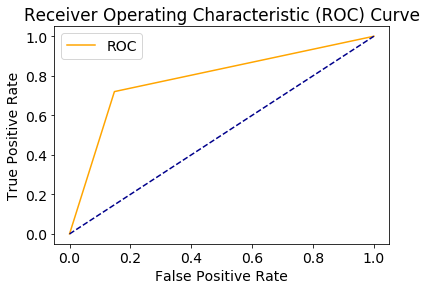

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

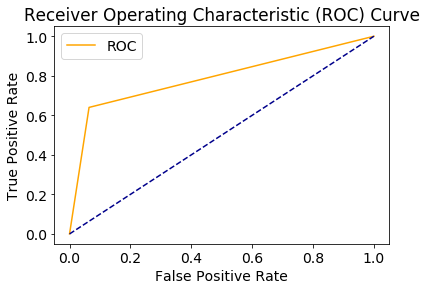

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

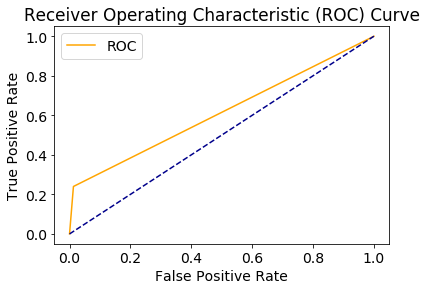

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

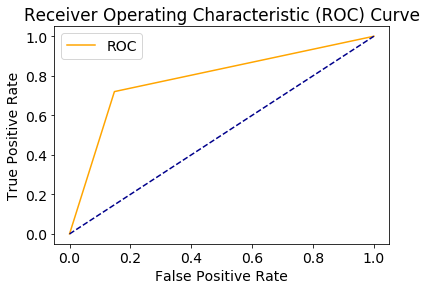

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

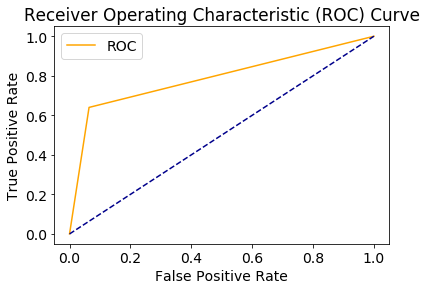

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.80      0.16      0.27        25

    accuracy                           0.88       181
   macro avg       0.84      0.58      0.60       181
weighted avg       0.87      0.88      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

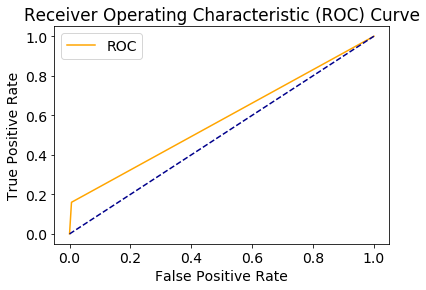

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

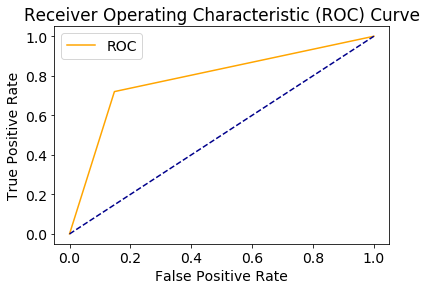

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

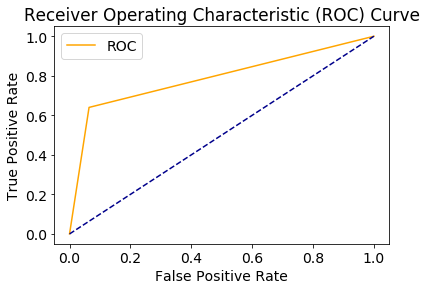

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

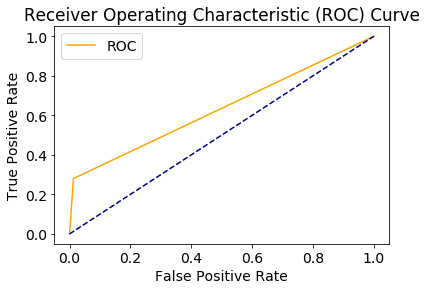

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

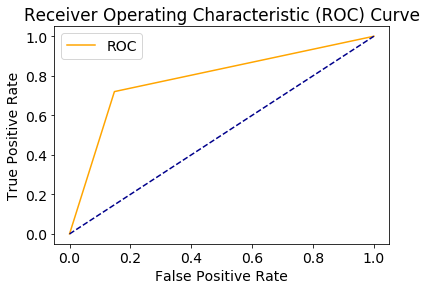

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

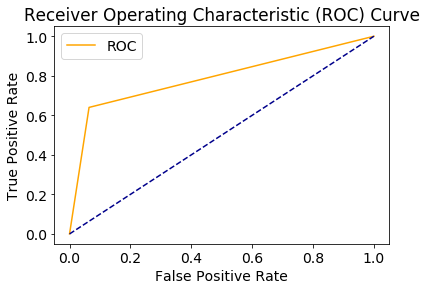

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

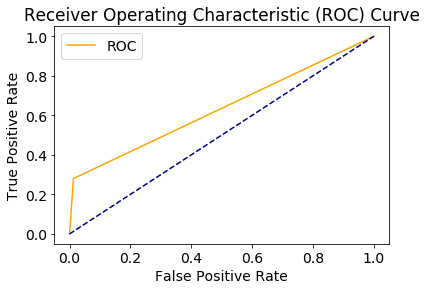

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

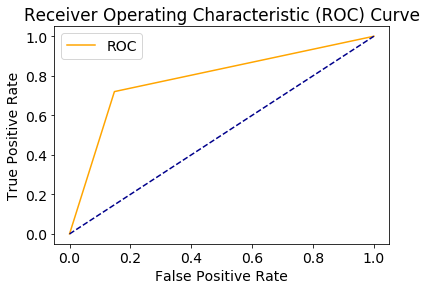

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

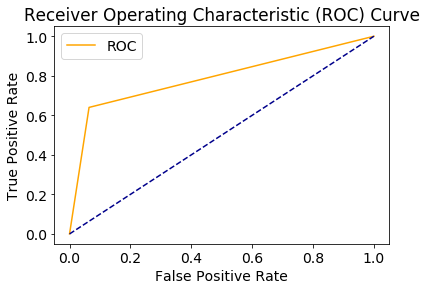

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

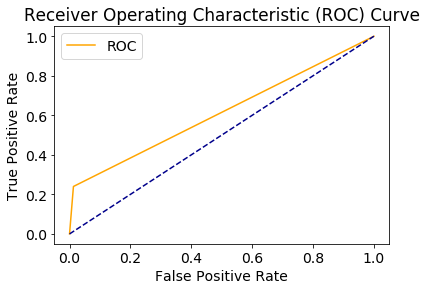

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

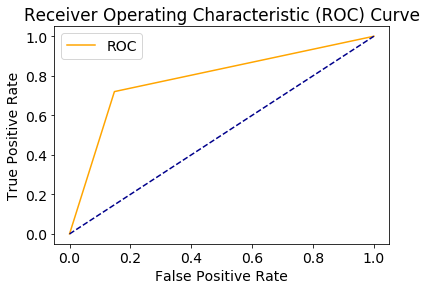

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

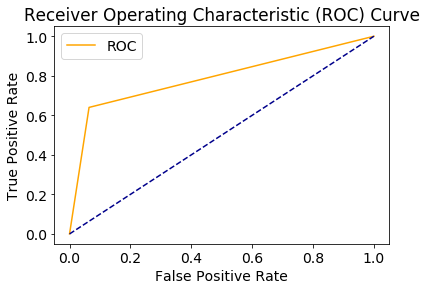

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

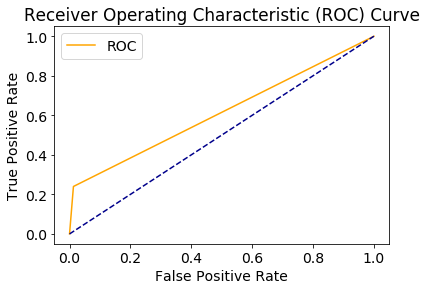

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

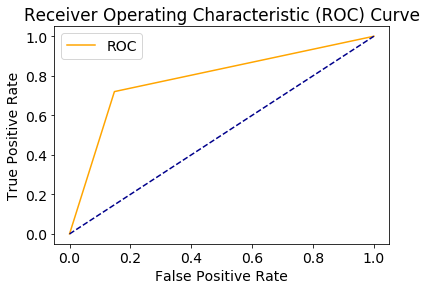

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

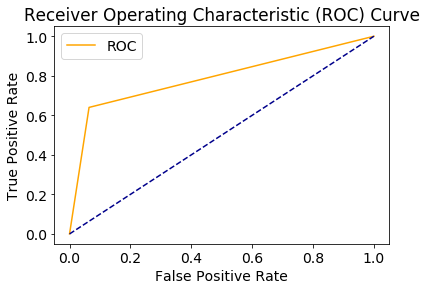

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.40
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.75      0.24      0.36        25

    accuracy                           0.88       181
   macro avg       0.82      0.61      0.65       181
weighted avg       0.87      0.88      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

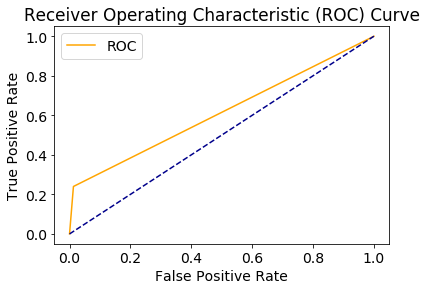

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

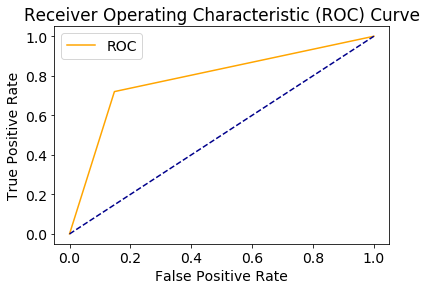

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

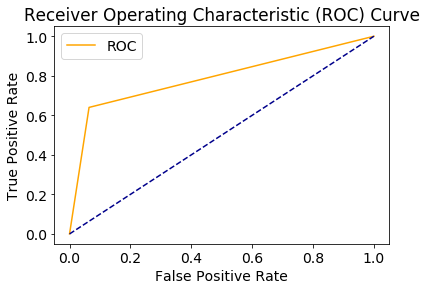

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

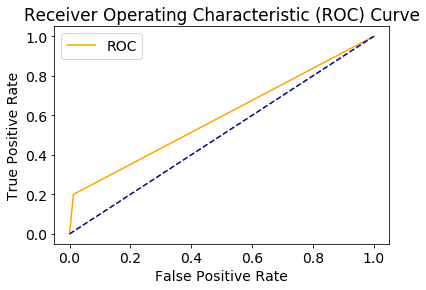

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

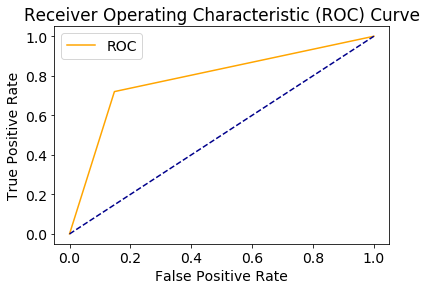

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

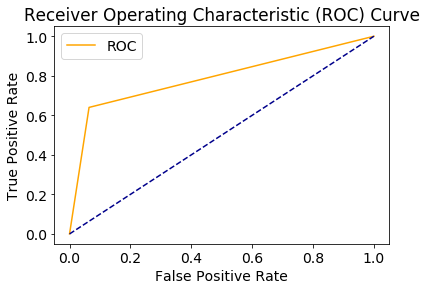

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.80      0.32      0.46        25

    accuracy                           0.90       181
   macro avg       0.85      0.65      0.70       181
weighted avg       0.89      0.90      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

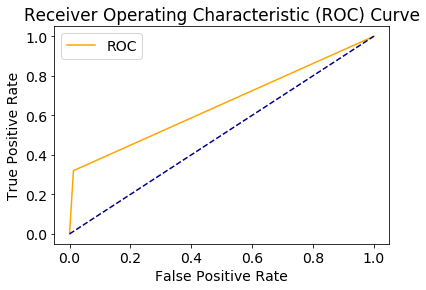

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

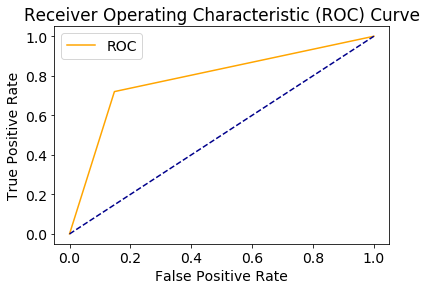

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

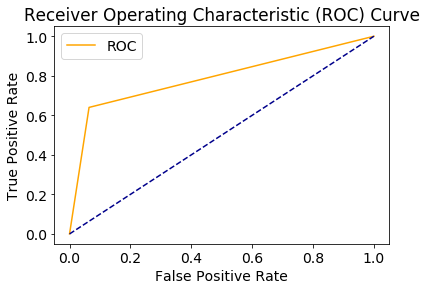

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

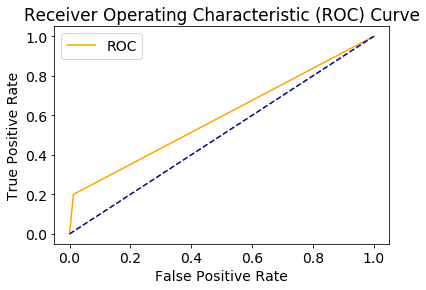

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

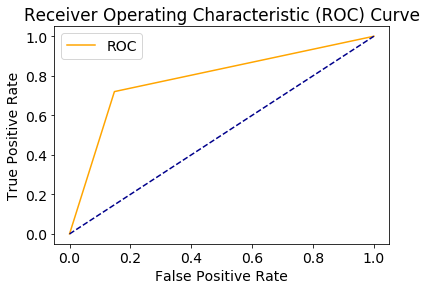

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

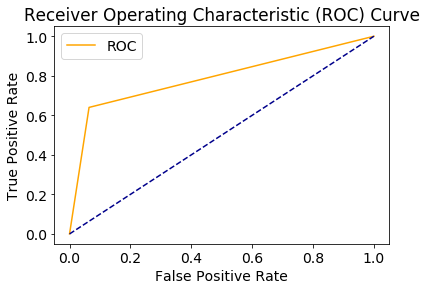

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.67      0.16      0.26        25

    accuracy                           0.87       181
   macro avg       0.77      0.57      0.59       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

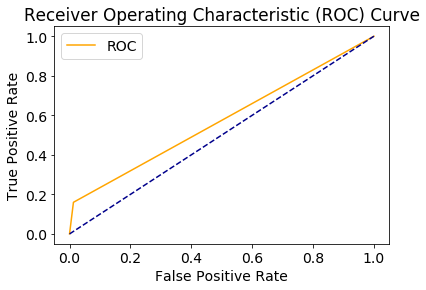

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

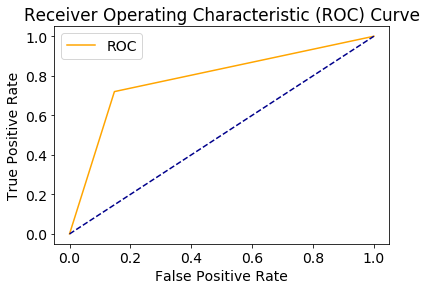

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

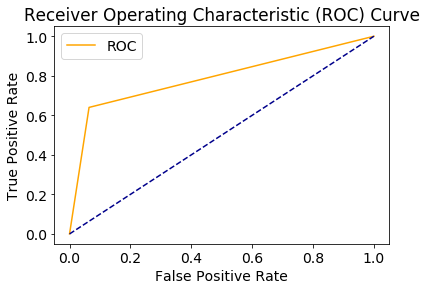

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.67      0.16      0.26        25

    accuracy                           0.87       181
   macro avg       0.77      0.57      0.59       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

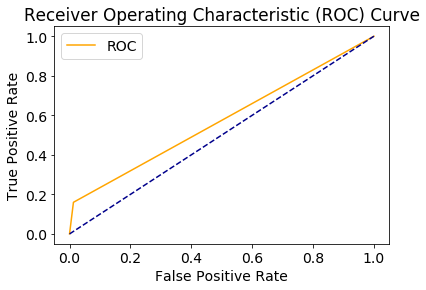

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

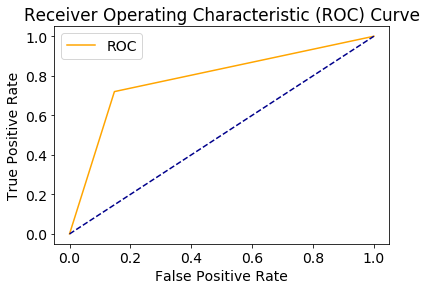

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

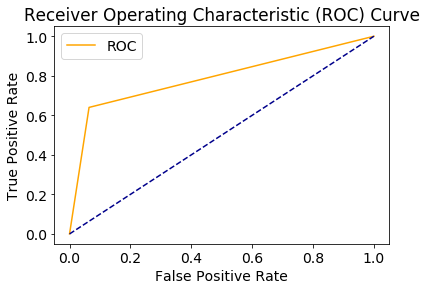

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       156
           1       0.78      0.28      0.41        25

    accuracy                           0.89       181
   macro avg       0.84      0.63      0.68       181
weighted avg       0.88      0.89      0.87       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

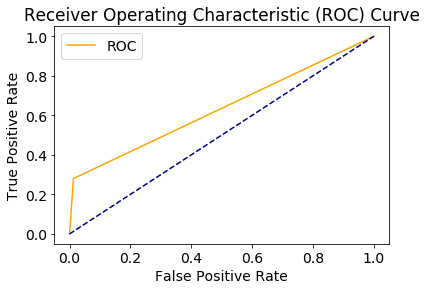

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

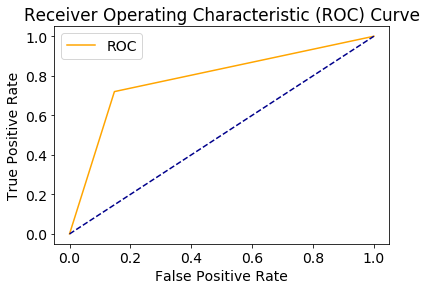

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

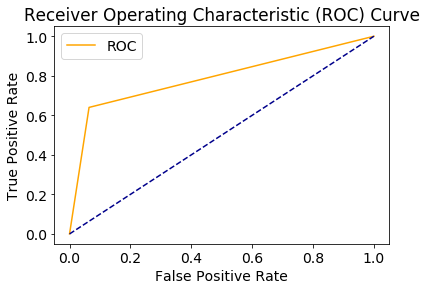

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 90.06
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.94       156
           1       0.82      0.36      0.50        25

    accuracy                           0.90       181
   macro avg       0.86      0.67      0.72       181
weighted avg       0.89      0.90      0.88       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

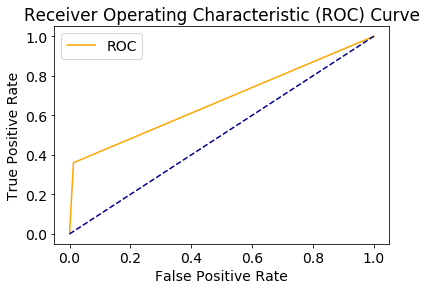

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

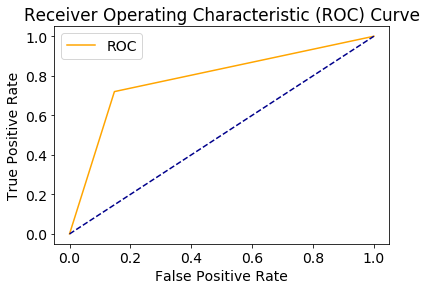

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

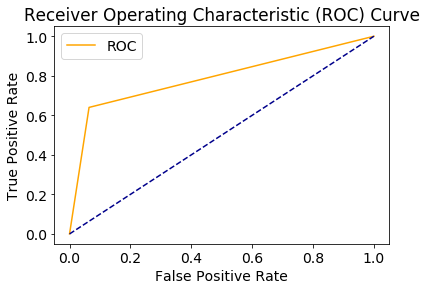

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 88.95
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.86      0.24      0.38        25

    accuracy                           0.89       181
   macro avg       0.87      0.62      0.66       181
weighted avg       0.89      0.89      0.86       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

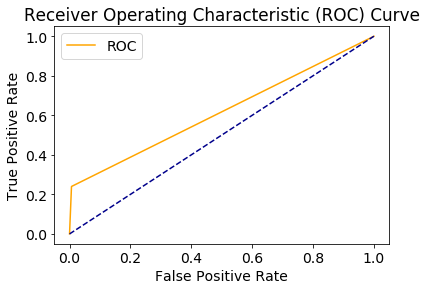

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

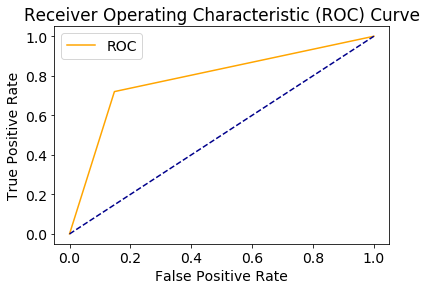

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

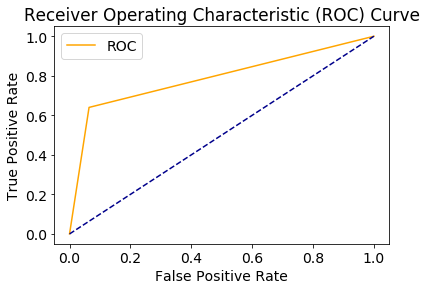

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       156
           1       0.62      0.20      0.30        25

    accuracy                           0.87       181
   macro avg       0.75      0.59      0.62       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

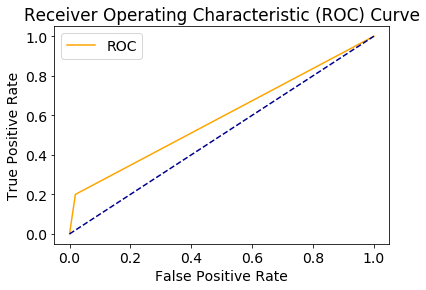

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

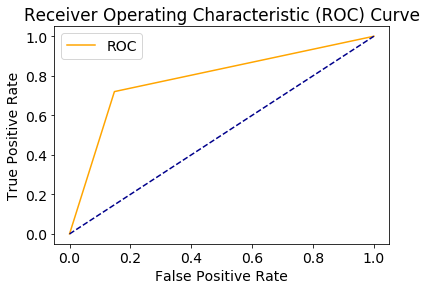

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

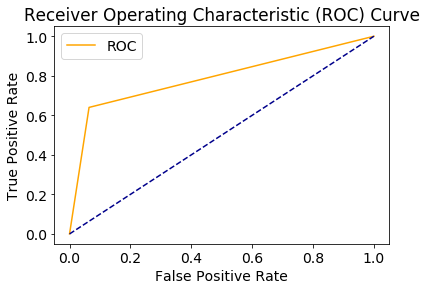

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

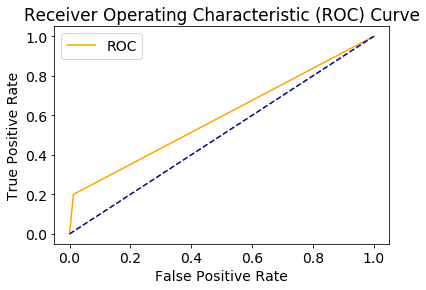

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

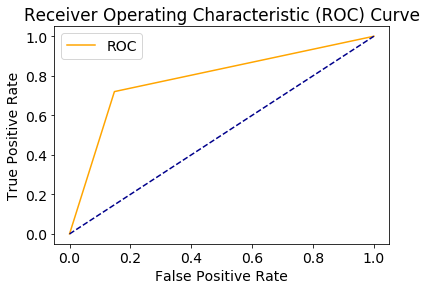

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

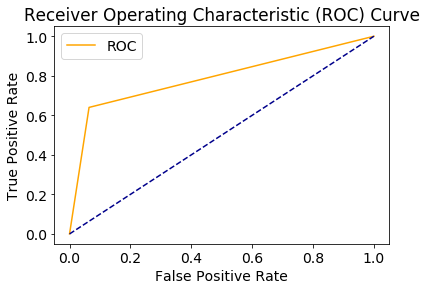

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 86.74
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       156
           1       0.57      0.16      0.25        25

    accuracy                           0.87       181
   macro avg       0.73      0.57      0.59       181
weighted avg       0.84      0.87      0.83       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

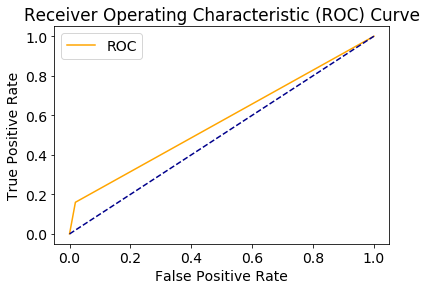

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

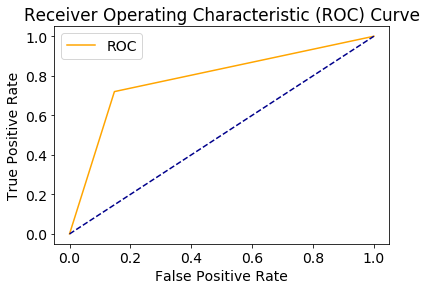

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

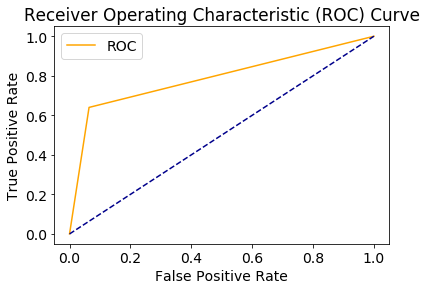

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       156
           1       0.71      0.20      0.31        25

    accuracy                           0.88       181
   macro avg       0.80      0.59      0.62       181
weighted avg       0.86      0.88      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

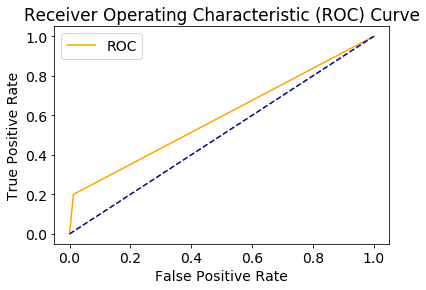

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

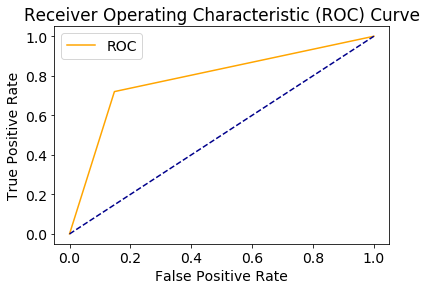

===============Multilayer Neural Networks====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 89.50
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.62      0.64      0.63        25

    accuracy                           0.90       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.90      0.90      0.90       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

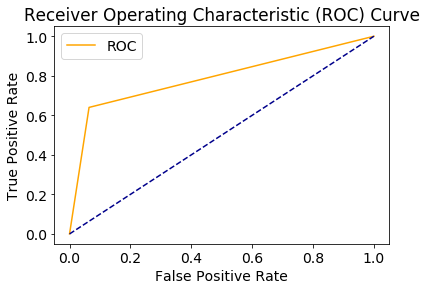

===============Randon Forest Results====================

-- Training data --
Accuracy: 100.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        58

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422

Confusion Matrix:
[[364   0]
 [  0  58]]


---- Test data ----
Accuracy: 87.29
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       156
           1       0.67      0.16      0.26        25

    accuracy                           0.87       181
   macro avg       0.77      0.57      0.59       181
weighted avg       0.85      0.87      0.84       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals in th

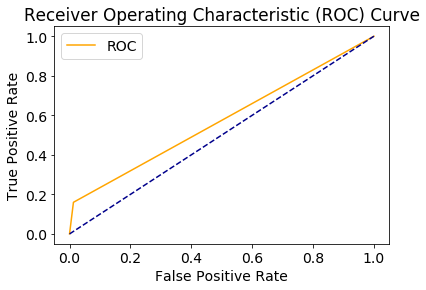

===============LOGISTIC REGRESSION Results====================

-- Training data --
Accuracy: 87.20
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       364
           1       0.52      0.91      0.66        58

    accuracy                           0.87       422
   macro avg       0.75      0.89      0.79       422
weighted avg       0.92      0.87      0.89       422

Confusion Matrix:
[[315  49]
 [  5  53]]


---- Test data ----
Accuracy: 83.43
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       156
           1       0.44      0.72      0.55        25

    accuracy                           0.83       181
   macro avg       0.69      0.79      0.72       181
weighted avg       0.88      0.83      0.85       181

Confusion Matrix:
***********
====================Prevalence original group =  0.13812154696132597
Number of individuals 

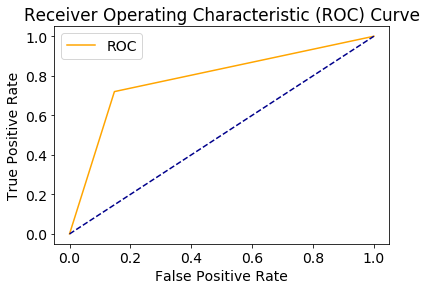

In [283]:
#################################################################################
#
#    GETTING THE AVERAGE RESULTS BY RUNNING "N" TIMES EACH OF THE CLASSFIERS 
#
################################################################################


RN_performance = pd.DataFrame(columns =['accuracy', 'length_G1', 'length_G2', 'prevalence_G1','prevalence_G2', 'sensitivity', 'especificity','auc', 'precision_1', 'recall_1', 'F_measure_1', 'precision_0', 'recall_0', 'F_measure_0'])

RF_performance = pd.DataFrame(columns =['accuracy', 'length_G1', 'length_G2','prevalence_G1','prevalence_G2', 'sensitivity', 'especificity','auc', 'precision_1', 'recall_1', 'F_measure_1', 'precision_0', 'recall_0', 'F_measure_0'])

Logistic_performance = pd.DataFrame(columns =['accuracy', 'length_G1', 'length_G2','prevalence_G1','prevalence_G2', 'sensitivity', 'especificity','auc', 'precision_1', 'recall_1', 'F_measure_1', 'precision_0', 'recall_0', 'F_measure_0'])

for i in range(100):
    print('===============Multilayer Neural Networks====================')
    length_G1=0
    length_G2=0
    prevalence_G1=0
    prevalence_G2=0
    sensitivity=0
    specificity=0
    accuracy,length_G1, length_G2, prevalence_G1,prevalence_G2, sensitivity, especificity, auc , precision_1, recall_1, F_measure_1, precision_0, recall_0, F_measure_0= train_and_evaluate(X_train, Y_train, X_test, Y_test, 'RN')
    RN_performance.loc[i,'accuracy']= accuracy
    RN_performance.loc[i,'length_G1']= length_G1
    RN_performance.loc[i,'length_G2']= length_G2
    RN_performance.loc[i,'prevalence_G1']=prevalence_G1
    RN_performance.loc[i,'prevalence_G2']=prevalence_G2
    RN_performance.loc[i,'sensitivity']=sensitivity
    RN_performance.loc[i,'especificity']=especificity
    RN_performance.loc[i,'auc']=auc
    RN_performance.loc[i,'precision_1']=precision_1
    RN_performance.loc[i,'recall_1']=recall_1
    RN_performance.loc[i,'F_measure_1']=F_measure_1
    RN_performance.loc[i,'precision_0']=precision_0
    RN_performance.loc[i,'recall_0']=recall_0
    RN_performance.loc[i,'F_measure_0']=F_measure_0

    print('===============Randon Forest Results====================')
    length_G1=0
    length_G2=0
    prevalence_G1=0
    prevalence_G2=0
    sensitivity=0
    specificity=0
    accuracy, length_G1, length_G2, prevalence_G1,prevalence_G2, sensitivity, especificity, auc , precision_1, recall_1, F_measure_1, precision_0, recall_0, F_measure_0= train_and_evaluate(X_train, Y_train, X_test, Y_test, 'RF')
    RF_performance.loc[i,'accuracy']= accuracy
    RF_performance.loc[i,'length_G1']= length_G1
    RF_performance.loc[i,'length_G2']= length_G2
    RF_performance.loc[i,'prevalence_G1']=prevalence_G1
    RF_performance.loc[i,'prevalence_G2']=prevalence_G2
    RF_performance.loc[i,'sensitivity']=sensitivity
    RF_performance.loc[i,'especificity']=especificity
    RF_performance.loc[i,'auc']=auc
    RF_performance.loc[i,'precision_1']=precision_1
    RF_performance.loc[i,'recall_1']=recall_1
    RF_performance.loc[i,'F_measure_1']=F_measure_1
    RF_performance.loc[i,'precision_0']=precision_0
    RF_performance.loc[i,'recall_0']=recall_0
    RF_performance.loc[i,'F_measure_0']=F_measure_0

    print('===============LOGISTIC REGRESSION Results====================')
    length_G1=0
    length_G2=0
    prevalence_G1=0
    prevalence_G2=0
    sensitivity=0
    specificity=0

    accuracy,length_G1, length_G2,  prevalence_G1,prevalence_G2, sensitivity, especificity, auc , precision_1, recall_1, F_measure_1, precision_0, recall_0, F_measure_0= train_and_evaluate(X_train, Y_train, X_test, Y_test, 'Logistic')
    Logistic_performance.loc[i,'accuracy']= accuracy
    Logistic_performance.loc[i,'length_G1']= length_G1
    Logistic_performance.loc[i,'length_G2']= length_G2
    Logistic_performance.loc[i,'prevalence_G1']=prevalence_G1
    Logistic_performance.loc[i,'prevalence_G2']=prevalence_G2
    Logistic_performance.loc[i,'sensitivity']=sensitivity
    Logistic_performance.loc[i,'especificity']=especificity
    Logistic_performance.loc[i,'auc']=auc
    Logistic_performance.loc[i,'precision_1']=precision_1
    Logistic_performance.loc[i,'recall_1']=recall_1
    Logistic_performance.loc[i,'F_measure_1']=F_measure_1
    Logistic_performance.loc[i,'precision_0']=precision_0
    Logistic_performance.loc[i,'recall_0']=recall_0
    Logistic_performance.loc[i,'F_measure_0']=F_measure_0

############################################
#   MEAN AND STANDARD DEVIATION CALCULATION
############################################
          
RN_MEAN_STD_performance = pd.DataFrame(columns =['accuracy', 'length_G1', 'length_G2','prevalence_G1','prevalence_G2', 'sensitivity', 'especificity','auc', 'precision_1', 'recall_1', 'F_measure_1', 'precision_0', 'recall_0', 'F_measure_0'])

RF_MEAN_STD_performance = pd.DataFrame(columns =['accuracy', 'length_G1', 'length_G2', 'prevalence_G1','prevalence_G2', 'sensitivity', 'especificity','auc', 'precision_1', 'recall_1', 'F_measure_1', 'precision_0', 'recall_0', 'F_measure_0'])

Logistic_MEAN_STD_performance = pd.DataFrame(columns =['accuracy', 'length_G1', 'length_G2', 'prevalence_G1','prevalence_G2', 'sensitivity', 'especificity','auc', 'precision_1', 'recall_1', 'F_measure_1', 'precision_0', 'recall_0', 'F_measure_0'])


############################################
#   MEAN AND STANDARD DEVIATION CALCULATION  -----> NEURAL NETWORKS
############################################

RN_MEAN_STD_performance.loc[0,'accuracy']= RN_performance.loc[:,'accuracy'].mean()
RN_MEAN_STD_performance.loc[0,'length_G1']= RN_performance.loc[:,'length_G1'].mean()
RN_MEAN_STD_performance.loc[0,'length_G2']= RN_performance.loc[:,'length_G2'].mean()

RN_MEAN_STD_performance.loc[0,'prevalence_G1']=RN_performance.loc[:,'prevalence_G1'].mean()
RN_MEAN_STD_performance.loc[0,'prevalence_G2']=RN_performance.loc[:,'prevalence_G2'].mean()
RN_MEAN_STD_performance.loc[0,'sensitivity']=RN_performance.loc[:,'sensitivity'].mean()
RN_MEAN_STD_performance.loc[0,'especificity']=RN_performance.loc[:,'especificity'].mean()
RN_MEAN_STD_performance.loc[0,'auc']=RN_performance.loc[:,'auc'].mean()
RN_MEAN_STD_performance.loc[0,'precision_1']=RN_performance.loc[:,'precision_1'].mean()
RN_MEAN_STD_performance.loc[0,'recall_1']=RN_performance.loc[:,'recall_1'].mean()
RN_MEAN_STD_performance.loc[0,'F_measure_1']=RN_performance.loc[:,'F_measure_1'].mean()
RN_MEAN_STD_performance.loc[0,'precision_0']=RN_performance.loc[:,'precision_0'].mean()
RN_MEAN_STD_performance.loc[0,'recall_0']=RN_performance.loc[:,'recall_0'].mean()
RN_MEAN_STD_performance.loc[0,'F_measure_0']=RN_performance.loc[:,'F_measure_0'].mean()

RN_MEAN_STD_performance.loc[1,'accuracy']= RN_performance.loc[:,'accuracy'].std()
RN_MEAN_STD_performance.loc[1,'length_G1']= RN_performance.loc[:,'length_G1'].std()
RN_MEAN_STD_performance.loc[1,'length_G2']= RN_performance.loc[:,'length_G2'].std()

RN_MEAN_STD_performance.loc[1,'prevalence_G1']=RN_performance.loc[:,'prevalence_G1'].std()
RN_MEAN_STD_performance.loc[1,'prevalence_G2']=RN_performance.loc[:,'prevalence_G2'].std()
RN_MEAN_STD_performance.loc[1,'sensitivity']=RN_performance.loc[:,'sensitivity'].std()
RN_MEAN_STD_performance.loc[1,'especificity']=RN_performance.loc[:,'especificity'].std()
RN_MEAN_STD_performance.loc[1,'auc']=RN_performance.loc[:,'auc'].std()
RN_MEAN_STD_performance.loc[1,'precision_1']=RN_performance.loc[:,'precision_1'].std()
RN_MEAN_STD_performance.loc[1,'recall_1']=RN_performance.loc[:,'recall_1'].std()
RN_MEAN_STD_performance.loc[1,'F_measure_1']=RN_performance.loc[:,'F_measure_1'].std()
RN_MEAN_STD_performance.loc[1,'precision_0']=RN_performance.loc[:,'precision_0'].std()
RN_MEAN_STD_performance.loc[1,'recall_0']=RN_performance.loc[:,'recall_0'].std()
RN_MEAN_STD_performance.loc[1,'F_measure_0']=RN_performance.loc[:,'F_measure_0'].std()


############################################
#   MEAN AND STANDARD DEVIATION CALCULATION  -----> RANDOM FOREST
############################################

RF_MEAN_STD_performance.loc[0,'accuracy']= RF_performance.loc[:,'accuracy'].mean()
RF_MEAN_STD_performance.loc[0,'length_G1']= RF_performance.loc[:,'length_G1'].mean()
RF_MEAN_STD_performance.loc[0,'length_G2']= RF_performance.loc[:,'length_G2'].mean()

RF_MEAN_STD_performance.loc[0,'prevalence_G1']=RF_performance.loc[:,'prevalence_G1'].mean()
RF_MEAN_STD_performance.loc[0,'prevalence_G2']=RF_performance.loc[:,'prevalence_G2'].mean()
RF_MEAN_STD_performance.loc[0,'sensitivity']=RF_performance.loc[:,'sensitivity'].mean()
RF_MEAN_STD_performance.loc[0,'especificity']=RF_performance.loc[:,'especificity'].mean()
RF_MEAN_STD_performance.loc[0,'auc']=RF_performance.loc[:,'auc'].mean()
RF_MEAN_STD_performance.loc[0,'precision_1']=RF_performance.loc[:,'precision_1'].mean()
RF_MEAN_STD_performance.loc[0,'recall_1']=RF_performance.loc[:,'recall_1'].mean()
RF_MEAN_STD_performance.loc[0,'F_measure_1']=RF_performance.loc[:,'F_measure_1'].mean()
RF_MEAN_STD_performance.loc[0,'precision_0']=RF_performance.loc[:,'precision_0'].mean()
RF_MEAN_STD_performance.loc[0,'recall_0']=RF_performance.loc[:,'recall_0'].mean()
RF_MEAN_STD_performance.loc[0,'F_measure_0']=RF_performance.loc[:,'F_measure_0'].mean()


RF_MEAN_STD_performance.loc[1,'accuracy']= RF_performance.loc[:,'accuracy'].std()
RF_MEAN_STD_performance.loc[1,'length_G1']= RF_performance.loc[:,'length_G1'].std()
RF_MEAN_STD_performance.loc[1,'length_G2']= RF_performance.loc[:,'length_G2'].std()

RF_MEAN_STD_performance.loc[1,'prevalence_G1']=RF_performance.loc[:,'prevalence_G1'].std()
RF_MEAN_STD_performance.loc[1,'prevalence_G2']=RF_performance.loc[:,'prevalence_G2'].std()
RF_MEAN_STD_performance.loc[1,'sensitivity']=RF_performance.loc[:,'sensitivity'].std()
RF_MEAN_STD_performance.loc[1,'especificity']=RF_performance.loc[:,'especificity'].std()
RF_MEAN_STD_performance.loc[1,'auc']=RF_performance.loc[:,'auc'].std()
RF_MEAN_STD_performance.loc[1,'precision_1']=RF_performance.loc[:,'precision_1'].std()
RF_MEAN_STD_performance.loc[1,'recall_1']=RF_performance.loc[:,'recall_1'].std()
RF_MEAN_STD_performance.loc[1,'F_measure_1']=RF_performance.loc[:,'F_measure_1'].std()
RF_MEAN_STD_performance.loc[1,'precision_0']=RF_performance.loc[:,'precision_0'].std()
RF_MEAN_STD_performance.loc[1,'recall_0']=RF_performance.loc[:,'recall_0'].std()
RF_MEAN_STD_performance.loc[1,'F_measure_0']=RF_performance.loc[:,'F_measure_0'].std()


          
############################################
#   MEAN AND STANDARD DEVIATION CALCULATION  -----> LOGISTIC REGRESSION
############################################

Logistic_MEAN_STD_performance.loc[0,'accuracy']= Logistic_performance.loc[:,'accuracy'].mean()
Logistic_MEAN_STD_performance.loc[0,'length_G1']= Logistic_performance.loc[:,'length_G1'].mean()
Logistic_MEAN_STD_performance.loc[0,'length_G2']= Logistic_performance.loc[:,'length_G2'].mean()

Logistic_MEAN_STD_performance.loc[0,'prevalence_G1']=Logistic_performance.loc[:,'prevalence_G1'].mean()
Logistic_MEAN_STD_performance.loc[0,'prevalence_G2']=Logistic_performance.loc[:,'prevalence_G2'].mean()
Logistic_MEAN_STD_performance.loc[0,'sensitivity']=Logistic_performance.loc[:,'sensitivity'].mean()
Logistic_MEAN_STD_performance.loc[0,'especificity']=Logistic_performance.loc[:,'especificity'].mean()
Logistic_MEAN_STD_performance.loc[0,'auc']=Logistic_performance.loc[:,'auc'].mean()
Logistic_MEAN_STD_performance.loc[0,'precision_1']=Logistic_performance.loc[:,'precision_1'].mean()
Logistic_MEAN_STD_performance.loc[0,'recall_1']=Logistic_performance.loc[:,'recall_1'].mean()
Logistic_MEAN_STD_performance.loc[0,'F_measure_1']=Logistic_performance.loc[:,'F_measure_1'].mean()
Logistic_MEAN_STD_performance.loc[0,'precision_0']=Logistic_performance.loc[:,'precision_0'].mean()
Logistic_MEAN_STD_performance.loc[0,'recall_0']=Logistic_performance.loc[:,'recall_0'].mean()
Logistic_MEAN_STD_performance.loc[0,'F_measure_0']=Logistic_performance.loc[:,'F_measure_0'].mean()


Logistic_MEAN_STD_performance.loc[1,'accuracy']= Logistic_performance.loc[:,'accuracy'].std()
Logistic_MEAN_STD_performance.loc[1,'length_G1']= Logistic_performance.loc[:,'length_G1'].std()
Logistic_MEAN_STD_performance.loc[1,'length_G2']= Logistic_performance.loc[:,'length_G2'].std()

Logistic_MEAN_STD_performance.loc[1,'prevalence_G1']=Logistic_performance.loc[:,'prevalence_G1'].std()
Logistic_MEAN_STD_performance.loc[1,'prevalence_G2']=Logistic_performance.loc[:,'prevalence_G2'].std()
Logistic_MEAN_STD_performance.loc[1,'sensitivity']=Logistic_performance.loc[:,'sensitivity'].std()
Logistic_MEAN_STD_performance.loc[1,'especificity']=Logistic_performance.loc[:,'especificity'].std()
Logistic_MEAN_STD_performance.loc[1,'auc']=Logistic_performance.loc[:,'auc'].std()
Logistic_MEAN_STD_performance.loc[1,'precision_1']=RN_performance.loc[:,'precision_1'].std()
Logistic_MEAN_STD_performance.loc[1,'recall_1']=RN_performance.loc[:,'recall_1'].std()
Logistic_MEAN_STD_performance.loc[1,'F_measure_1']=RN_performance.loc[:,'F_measure_1'].std()
Logistic_MEAN_STD_performance.loc[1,'precision_0']=RN_performance.loc[:,'precision_0'].std()
Logistic_MEAN_STD_performance.loc[1,'recall_0']=RN_performance.loc[:,'recall_0'].std()
Logistic_MEAN_STD_performance.loc[1,'F_measure_0']=RN_performance.loc[:,'F_measure_0'].std()



In [284]:
Logistic_MEAN_STD_performance

accuracy length_G1 length_G2 prevalence_G1 prevalence_G2  sensitivity  \
0     0.834254       140        41          0.05      0.439024     0.439024   
1  2.23163e-16         0         0   1.39477e-17   5.57908e-17  5.57908e-17   

  especificity          auc  precision_1     recall_1  F_measure_1  \
0     0.852564     0.786282     0.439024         0.72     0.545455   
1  2.23163e-16  3.34745e-16  2.23163e-16  1.11582e-16  2.23163e-16   

   precision_0     recall_0 F_measure_0  
0         0.95     0.852564    0.898649  
1  4.46326e-16  1.11582e-16           0

In [285]:
RF_MEAN_STD_performance


accuracy length_G1 length_G2 prevalence_G1 prevalence_G2 sensitivity  \
0    0.881768    173.06      7.94      0.111077      0.724291    0.724291   
1  0.00652294   1.33953   1.33953    0.00588566     0.0577183   0.0577183   

  especificity        auc precision_1   recall_1 F_measure_1 precision_0  \
0      0.98609   0.608445    0.724291     0.2308    0.348306    0.888923   
1   0.00329201  0.0228481   0.0577183  0.0461373   0.0571031  0.00588566   

     recall_0 F_measure_0  
0     0.98609    0.934975  
1  0.00329201  0.00341601

In [286]:
RN_MEAN_STD_performance


accuracy length_G1 length_G2 prevalence_G1 prevalence_G2  sensitivity  \
0  0.895028       155        26     0.0580645      0.615385     0.615385   
1         0         0         0   6.97385e-18   2.23163e-16  2.23163e-16   

  especificity          auc  precision_1     recall_1  F_measure_1  \
0     0.935897     0.787949     0.615385         0.64     0.627451   
1  1.11582e-16  2.23163e-16  2.23163e-16  1.11582e-16  2.23163e-16   

   precision_0     recall_0 F_measure_0  
0     0.941935     0.935897    0.938907  
1  4.46326e-16  1.11582e-16           0

In [290]:
603*0.7

422.09999999999997

In [291]:
181+422

603